
# Developing Neural Network Models to Predict Trends in Dublin's Rental Property Market

This notebook is part of a thesis work aimed at developing neural network models, specifically Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks, to predict trends in Dublin's rental property market. The dataset used in this analysis is titled "RTB Average Monthly Rent Report".

Link: https://data.cso.ie/table/RIA02

- License: Attribution 4.0 International Creative Commons

### Dataset Overview
The dataset consists of the following columns:
- STATISTIC Label: Describes the statistical data (in this case, always "RTB Average Monthly Rent Report").
- Year: The year when the data was recorded.
- Number of Bedrooms: Number of bedrooms in the rental property.
- Property Type: The type of rental property.
- Location: The location of the property.
- UNIT: The unit of the rental value (Euro).
- VALUE: The average monthly rent in Euros.


# 1. Data 

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings  # filter warnings
warnings.filterwarnings('ignore')

# Loading the dataset
df = pd.read_csv('RTB Average Monthly Rent Report.csv')
df.head()

STATISTIC Label  Year Number of Bedrooms  \
0  RTB Average Monthly Rent Report  2008       All bedrooms   
1  RTB Average Monthly Rent Report  2008       All bedrooms   
2  RTB Average Monthly Rent Report  2008       All bedrooms   
3  RTB Average Monthly Rent Report  2008       All bedrooms   
4  RTB Average Monthly Rent Report  2008       All bedrooms   

        Property Type               Location  UNIT   VALUE  
0  All property types                 Carlow  Euro  748.48  
1  All property types            Carlow Town  Euro  811.53  
2  All property types  Graiguecullen, Carlow  Euro  711.35  
3  All property types         Tullow, Carlow  Euro  720.04  
4  All property types                  Cavan  Euro  571.72

In [2]:
print(df.shape)

(299712, 7)


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   STATISTIC Label     299712 non-null  object 
 1   Year                299712 non-null  int64  
 2   Number of Bedrooms  299712 non-null  object 
 3   Property Type       299712 non-null  object 
 4   Location            299712 non-null  object 
 5   UNIT                299712 non-null  object 
 6   VALUE               104665 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 16.0+ MB
None


# 2. Exploratory Data Analysis

### Checking for missing values

In [4]:
## Missing Data Analysis

# Checking for missing values
missing_values = df.isnull().sum()
missing_values

STATISTIC Label            0
Year                       0
Number of Bedrooms         0
Property Type              0
Location                   0
UNIT                       0
VALUE                 195047
dtype: int64

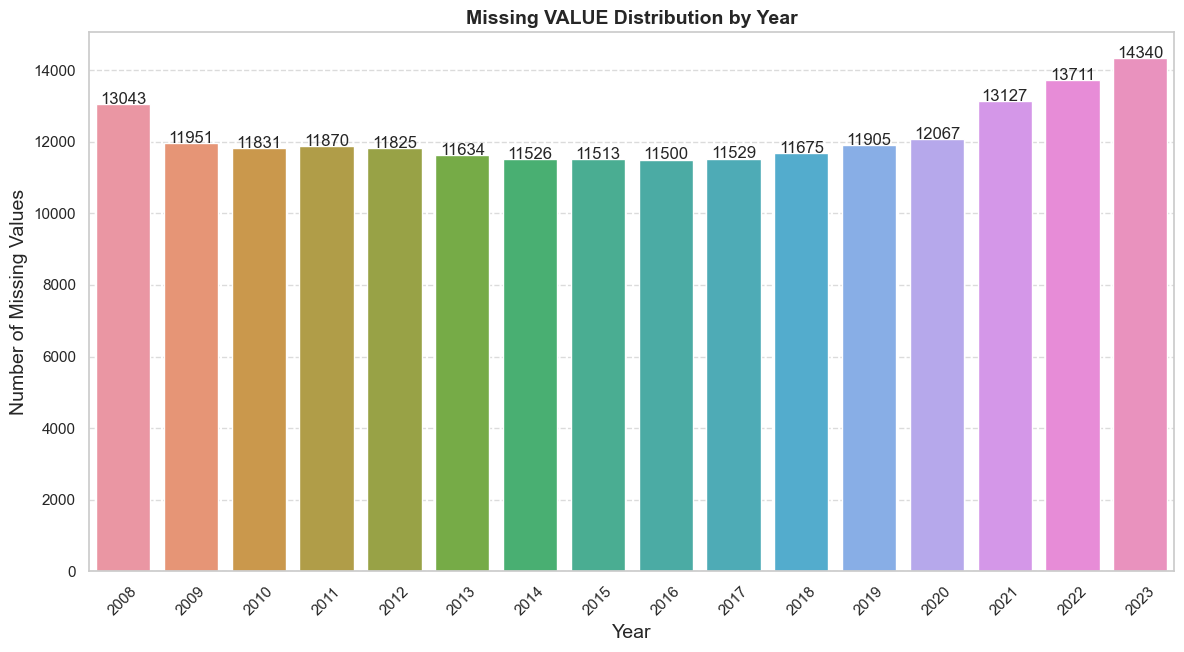

In [5]:
# Visualizing missing data distribution by Year with enhanced style
missing_distribution = df[df['VALUE'].isnull()]['Year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.barplot(x=missing_distribution.index, y=missing_distribution.values)

# Adding values on top of bars
for index, value in enumerate(missing_distribution.values):
    plt.text(index, value + 5, f'{value}', ha='center', fontsize=12)

plt.title('Missing VALUE Distribution by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

- The column that stores the rental values has a significant number of missing values, which can negatively influence the model if not treated correctly.
- The dataset has 299,712 rows, and 195,047 rows were found with missing values, leaving only 104,665 rows with values, which means that the dataset has a total of approximately 65.1% of missing values. This represents a significant amount of missing data, which could distort the analysis and impair the predictive capacity of the model. 

### Dealing with missing values

- To deal with these missing values, an imputation strategy was implemented using a progressive three-step approach.
- Imputation by mean based on year and location. The first attempt at filling in the missing values was made by calculating the mean of the rental values for each combination of year and location. This ensures that the imputation maintains the temporal and geographic relationship of the data, preserving possible local or annual patterns. 
- Imputation by annual mean, for cases where there were still missing values after the first step, a new imputation was performed, this time using only the annual mean. This approach seeks to generalize the rental values for a given year, ignoring differences by location. 
- Finally, there was an imputation with the overall median, for any missing values remaining after the previous steps, the global median value of the rentals was used, ensuring that all missing values were filled in. These procedures ensured that all missing values were handled appropriately, allowing the full use of the dataset in subsequent stages of the project.

In [6]:
# Creating a copy of the original dataframe
df1 = df.copy()

# Step 1: Impute missing values with the mean of each combination of Year and Location
df1['VALUE'] = df1.groupby(['Year', 'Location'])['VALUE'].transform(lambda x: x.fillna(x.mean()))

# Step 2: Check if there are still missing values after the first imputation
missing_after_first_step = df1['VALUE'].isnull().sum()
print(f"Missing values after imputing by Year and Location: {missing_after_first_step}")

# Step 3: If there are still missing values, impute with the annual mean (Year only)
df1['VALUE'] = df1.groupby('Year')['VALUE'].transform(lambda x: x.fillna(x.mean()))

# Step 4: Check if there are still missing values after imputing by year
missing_after_second_step = df1['VALUE'].isnull().sum()
print(f"Missing values after imputing by Year: {missing_after_second_step}")

# Step 5: If there are still missing values, fill with the overall median
if missing_after_second_step > 0:
    overall_median = df1['VALUE'].median()
    df1['VALUE'].fillna(overall_median, inplace=True)

# Final check to ensure all missing values have been imputed
missing_after_final_step = df1['VALUE'].isnull().sum()
print(f"Missing values after all imputations: {missing_after_final_step}")


Missing values after imputing by Year and Location: 17514
Missing values after imputing by Year: 0
Missing values after all imputations: 0


### Checking for Infinite Values in a DataFrame

In [7]:
import numpy as np

# Replace infinite values with NaN temporarily to count them
def check_infinite_values(df):
    # Temporarily replace infinities with NaN
    inf_count = df.replace([np.inf, -np.inf], np.nan).isna().sum()
    
    # Filter out columns with no infinite values
    inf_count = inf_count[inf_count > 0]
    
    # Display the columns with infinite values and their respective counts
    if not inf_count.empty:
        print("Columns with infinite values and their counts:")
        print(inf_count)
    else:
        print("No infinite values found in the DataFrame.")

# Call the function to check for infinite values in df1
check_infinite_values(df1)


No infinite values found in the DataFrame.


###  Check for duplicate rows

In [8]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Optionally, display the duplicate rows
duplicates = df[df.duplicated()]
print(duplicates)

Number of duplicate rows: 0
Empty DataFrame
Columns: [STATISTIC Label, Year, Number of Bedrooms, Property Type, Location, UNIT, VALUE]
Index: []


In [9]:
# Check which rows have NaN in the 'VALUE' column
nan_rows = df1[df1['VALUE'].isna()]
print(nan_rows.head())  # Display the first few rows with NaN in 'VALUE'

Empty DataFrame
Columns: [STATISTIC Label, Year, Number of Bedrooms, Property Type, Location, UNIT, VALUE]
Index: []


### Detect outliers using the IQR method with adjusted multiplier

- Outliers are identified using the IQR (Interquartile Range) method. In this case, the multiplier was set to 3, which allows us to detect extreme points that may be outliers but, as they are high-value properties, can be kept in the dataset. Outliers that are above the upper limit are justified as high-value properties and will be kept in the dataset. 
- Using this approach, 352 outliers were identified, but it was decided that high values above the upper limit would be kept in the dataset, until the filtering stage of the data focused on Dublin, since they represent high-value properties in the real estate market.

In [10]:
# Detect outliers using the IQR method with adjusted multiplier
def detect_outliers_iqr_adjusted(df, column, multiplier=3):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers with multiplier {multiplier}: {len(outliers)}")
    
    # Return the bounds and outliers
    return outliers, lower_bound, upper_bound

# Apply the function and retain outliers
outliers_iqr_adjusted, lower_bound, upper_bound = detect_outliers_iqr_adjusted(df1, 'VALUE', multiplier=3)

# Justify keeping high-value outliers
print(f"Outliers found above the upper bound ({upper_bound}) are justified as high-value properties and will be kept in the dataset.")

# Examples of high-value outliers
high_value_outliers = outliers_iqr_adjusted[outliers_iqr_adjusted['VALUE'] > upper_bound]
print("Examples of high-value outliers that will be retained:")
print(high_value_outliers.head(10))

# Final dataset including outliers, named as df2
df2 = df1.copy()

# Confirm the dataset is ready for further analysis
print("The dataset has been defined as df2 and is ready for further analysis.")


Number of outliers with multiplier 3: 352
Outliers found above the upper bound (3113.465000000001) are justified as high-value properties and will be kept in the dataset.
Examples of high-value outliers that will be retained:
                        STATISTIC Label  Year Number of Bedrooms  \
72352   RTB Average Monthly Rent Report  2011      Four plus bed   
74135   RTB Average Monthly Rent Report  2011      Four plus bed   
74136   RTB Average Monthly Rent Report  2011      Four plus bed   
91084   RTB Average Monthly Rent Report  2012      Four plus bed   
92633   RTB Average Monthly Rent Report  2012      Four plus bed   
92867   RTB Average Monthly Rent Report  2012      Four plus bed   
92868   RTB Average Monthly Rent Report  2012      Four plus bed   
109816  RTB Average Monthly Rent Report  2013      Four plus bed   
111600  RTB Average Monthly Rent Report  2013      Four plus bed   
114203  RTB Average Monthly Rent Report  2014       All bedrooms   

             Property Typ

### Visualize the outliers in the context of time (by year)

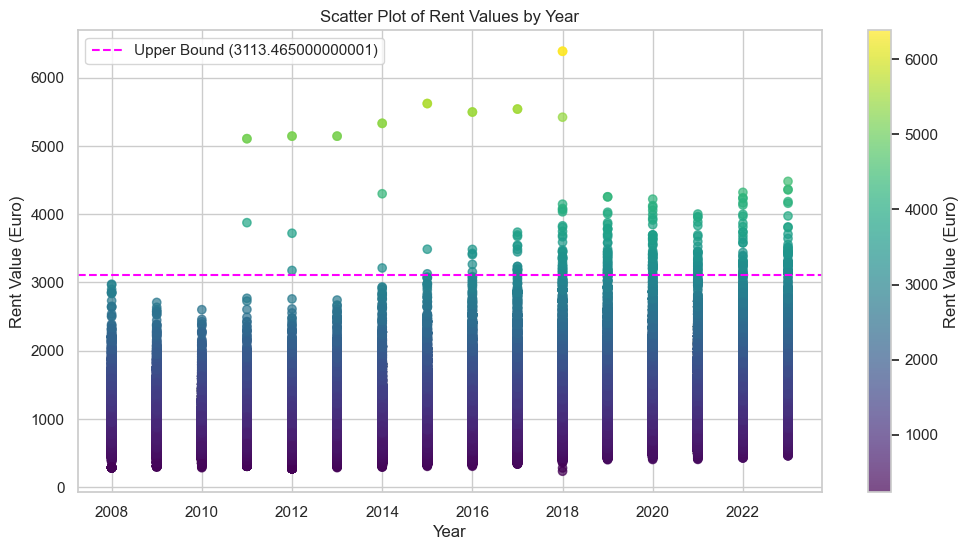

In [11]:
import numpy as np

plt.figure(figsize=(12, 6))

# Use a colormap for more colorful points based on the rent value
scatter = plt.scatter(df2['Year'], df2['VALUE'], c=df2['VALUE'], cmap='viridis', alpha=0.7)

# Add a color bar for reference
plt.colorbar(scatter, label='Rent Value (Euro)')

# Titles and labels
plt.title('Scatter Plot of Rent Values by Year')
plt.xlabel('Year')
plt.ylabel('Rent Value (Euro)')

# Highlight the upper bound for outliers
plt.axhline(y=upper_bound, color='magenta', linestyle='--', label=f'Upper Bound ({upper_bound})')

plt.legend()
plt.show()

- Properly handling missing values and justifying outliers were essential to ensure data quality and integrity, given the various tests performed, thus ruling out the possibility of completely removing missing values and placing a greater limit on flexibility in outlier detection. This visualization allowed us to identify the high-value properties that will be maintained, providing a visual context that reinforces the decision not to remove these data.

## 3. Data Visualization

### Trends over Years

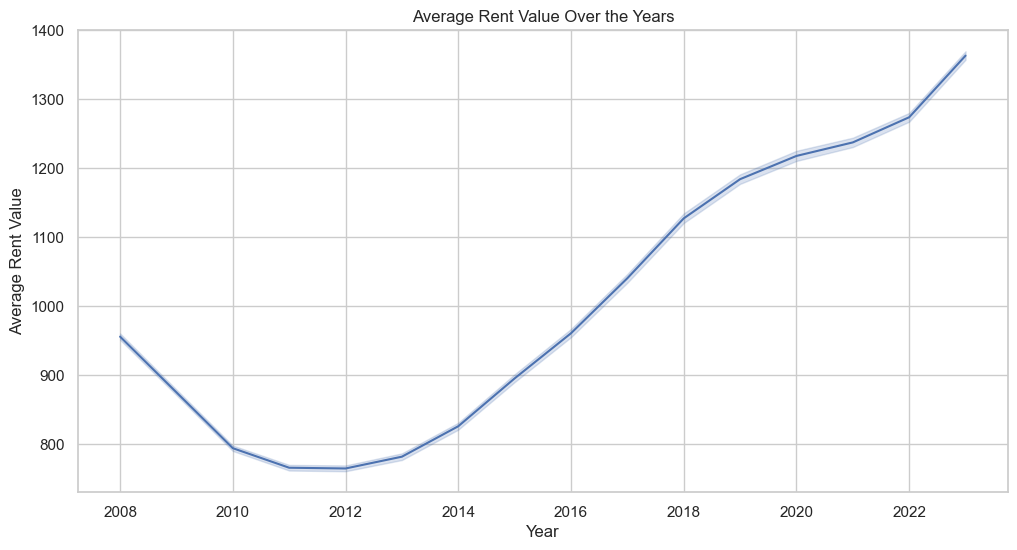

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trends over Years
plt.figure(figsize=(12, 6))
sns.lineplot(data=df2, x='Year', y='VALUE')
plt.title('Average Rent Value Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rent Value')
plt.grid(True)
plt.show()

- Rising or falling rental values over time can indicate economic cycles, government policies such as rental market regulations, or changes in housing demand in Dublin and other regions of Ireland. The presence of a grid makes it easier to read the values over time, making it easier to compare year-to-year changes.

### Rent Values by Top 10 Locations

In [13]:
import plotly.express as px

# Rent Values by Top 10 Locations
top_locations = df2['Location'].value_counts().nlargest(10).index
filtered_data = df2[df2['Location'].isin(top_locations)]
fig = px.box(filtered_data, x='Location', y='VALUE', color='Location', title='Rent Values by Top 10 Locations')
fig.update_xaxes(categoryorder='total descending')
fig.show()

- This graph selects the 10 locations that appear most frequently in the dataset used. In other words, it selects the 10 most common cities in the database, based only on the number of records. This shows me that this dataset, even though it is considered large, with data from 2008 to 2023, one of the most populous cities that is the focus of this study, is being underreported by the public regulatory authority RTB regarding Dublin.

### Histograms for Dublin and 6 most frequent cities for comparation

In [14]:
# Identify the top cities (excluding Dublin)
top_cities = df2['Location'].value_counts().head(6).index  # Select the 6 most frequent cities
top_cities = top_cities[top_cities.str.contains('Dublin', case=False) == False]  # Exclude Dublin

# Add Dublin to the list of cities for comparison
top_cities = top_cities.insert(0, 'Dublin')

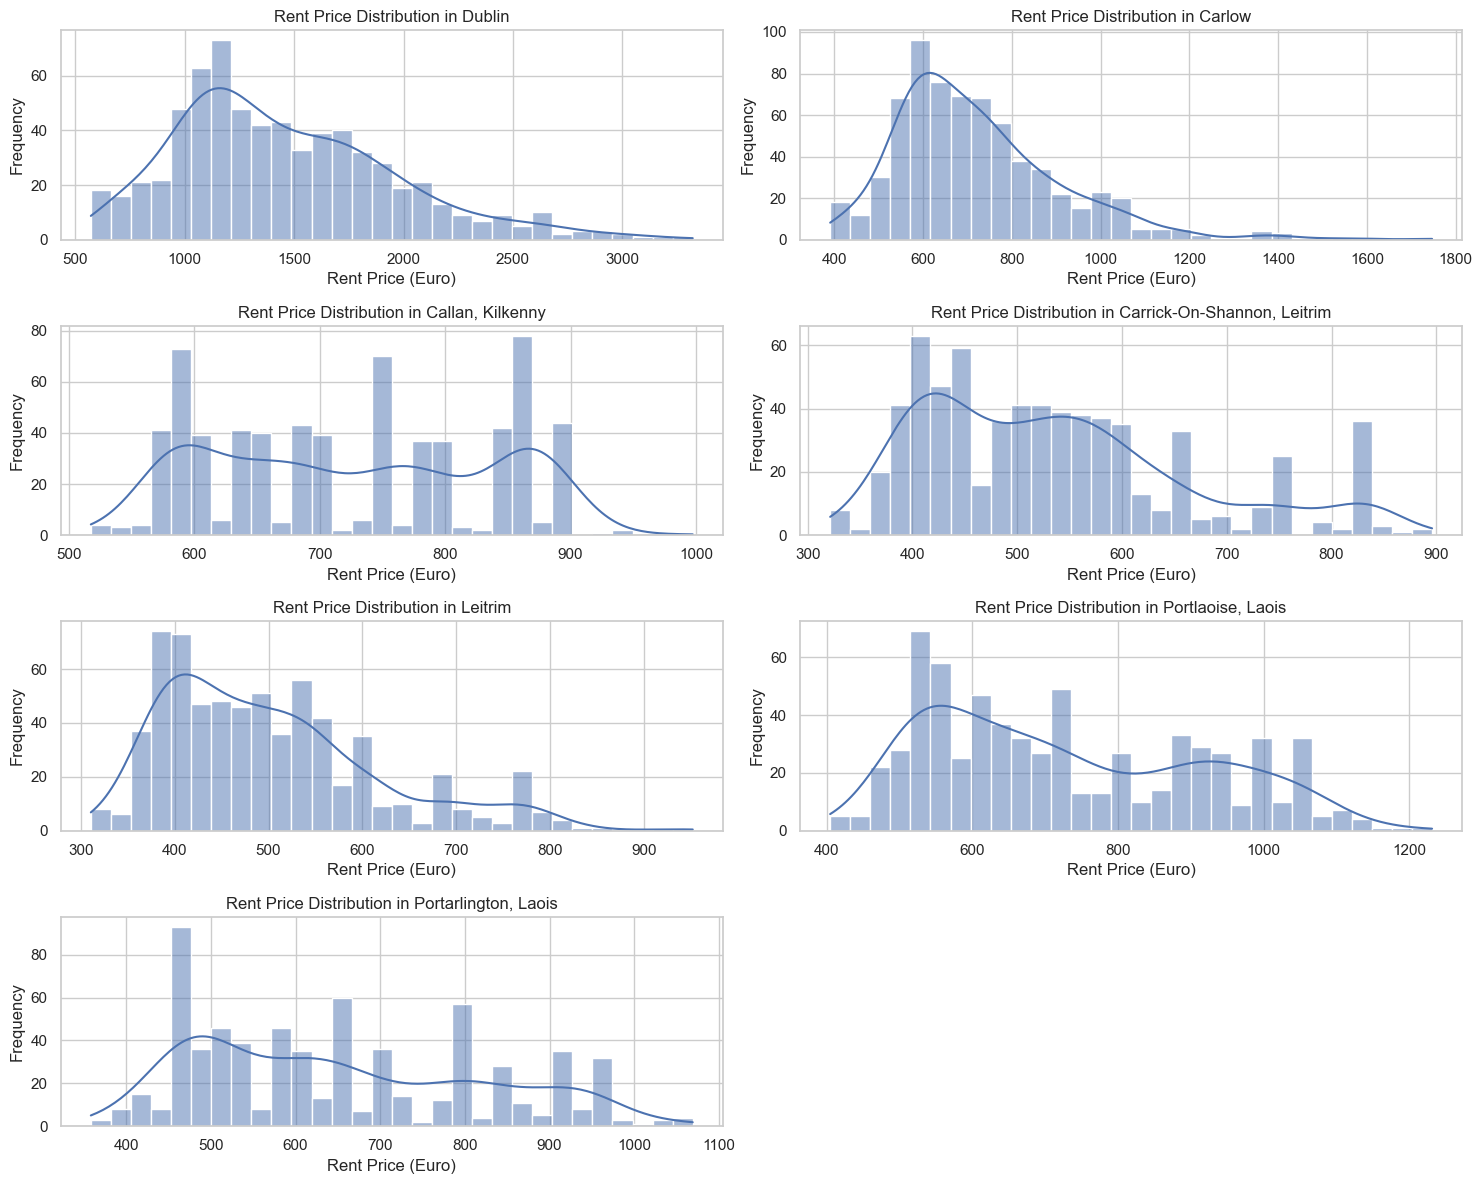

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to include only the selected cities
df_cities = df2[df2['Location'].isin(top_cities)]

# Plot histograms for Dublin and the selected cities
plt.figure(figsize=(15, 12))

for i, city in enumerate(top_cities):
    plt.subplot(4, 2, i + 1)  # Adjust the grid size based on the number of cities
    sns.histplot(df_cities[df_cities['Location'] == city]['VALUE'], kde=True, bins=30)
    plt.title(f'Rent Price Distribution in {city}')
    plt.xlabel('Rent Price (Euro)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- The Histograms suggest that urban areas, such as Dublin, have a more concentrated and predictable distribution of rents, while smaller or rural areas show greater variability. The presence of long tails in several regions suggests that there are premium properties in markets with lower average prices. This variability reflects the disparity in the rental housing market in Ireland, with Dublin standing out as the most expensive and diverse market, and areas such as Leitrim and Carlow having significantly lower prices. These charts are essential for visualizing market trends and understanding how rental prices vary across regions, which is crucial for accurately modeling price trends and predicting future market behavior.

### Average Monthly Rent by Property Type in Ireland

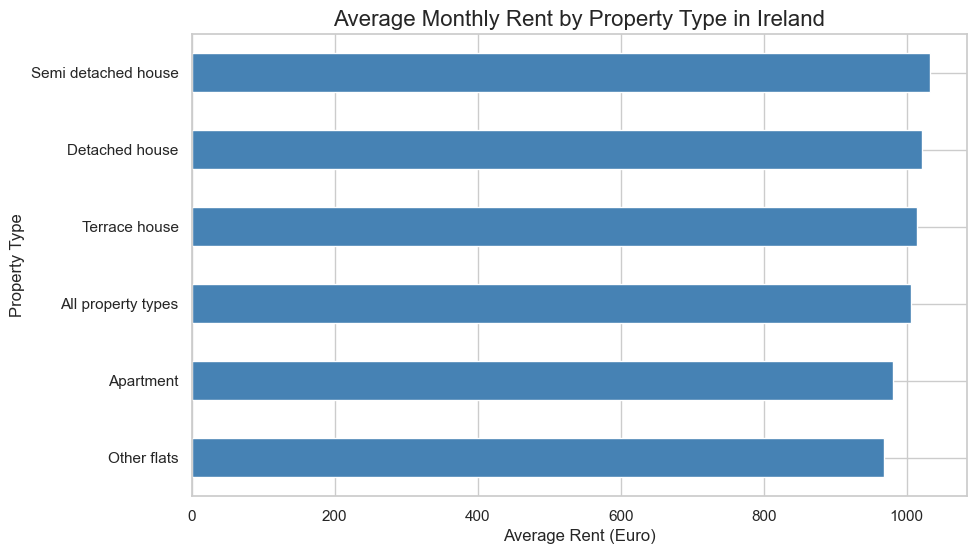

In [16]:
import matplotlib.pyplot as plt

# Grouping data by property type and calculating the average rent (VALUE)
average_rent_by_property = df2.groupby('Property Type')['VALUE'].mean().sort_values()

# Plotting the data
plt.figure(figsize=(10, 6))
average_rent_by_property.plot(kind='barh', color='steelblue')

# Adding titles and labels
plt.title('Average Monthly Rent by Property Type in Ireland', fontsize=16)
plt.xlabel('Average Rent (Euro)', fontsize=12)
plt.ylabel('Property Type', fontsize=12)

# Display the plot
plt.show()


- The visualization provides insights into the average price of each property type, allowing you to identify which types of properties are more expensive or more affordable in terms of rent. Rental behavior across different property types reflects tenant preferences, the size and standard of the dwellings, and the demographics of those renting those properties. 

### Average Monthly Rent by Number of Bedrooms

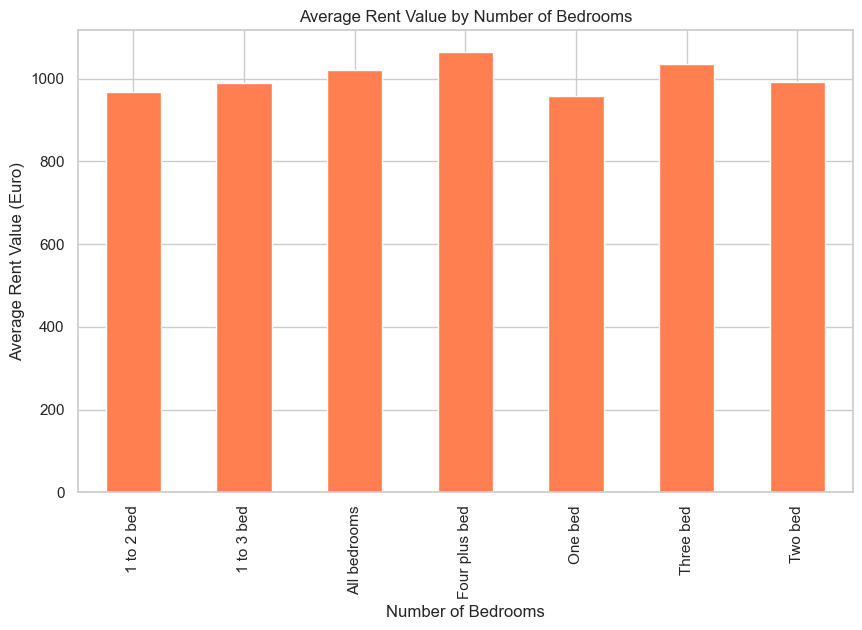

In [17]:
plt.figure(figsize=(10, 6))
df2.groupby('Number of Bedrooms')['VALUE'].mean().plot(kind='bar', color='coral')
plt.title('Average Rent Value by Number of Bedrooms')
plt.ylabel('Average Rent Value (Euro)')
plt.show()


- This visualization can also reveal non-linear price discrepancies, where an increase in the number of bedrooms may not correspond to a proportional increase in price, depending on the region.


# 4. EDA Dublin Data

In [18]:
# Filter for rows where 'Location' contains 'Dublin' to create df3
df3 = df2[df2['Location'].str.contains('Dublin', case=False, na=False)]

# Show the first few rows of df3 to confirm the filtering
print(df3.head())

# Save df3 for future analysis and predictions
df3.to_csv('dublin_rental_data.csv', index=False)

print("Filtered dataset for Dublin saved as 'dublin_rental_data.csv'.")

                    STATISTIC Label  Year Number of Bedrooms  \
71  RTB Average Monthly Rent Report  2008       All bedrooms   
72  RTB Average Monthly Rent Report  2008       All bedrooms   
73  RTB Average Monthly Rent Report  2008       All bedrooms   
74  RTB Average Monthly Rent Report  2008       All bedrooms   
75  RTB Average Monthly Rent Report  2008       All bedrooms   

         Property Type             Location  UNIT        VALUE  
71  All property types               Dublin  Euro  1271.310000  
72  All property types   Balbriggan, Dublin  Euro  1033.330000  
73  All property types    Blackrock, Dublin  Euro  1587.100000  
74  All property types  Booterstown, Dublin  Euro  1656.820000  
75  All property types   Cabinteely, Dublin  Euro   955.819531  
Filtered dataset for Dublin saved as 'dublin_rental_data.csv'.


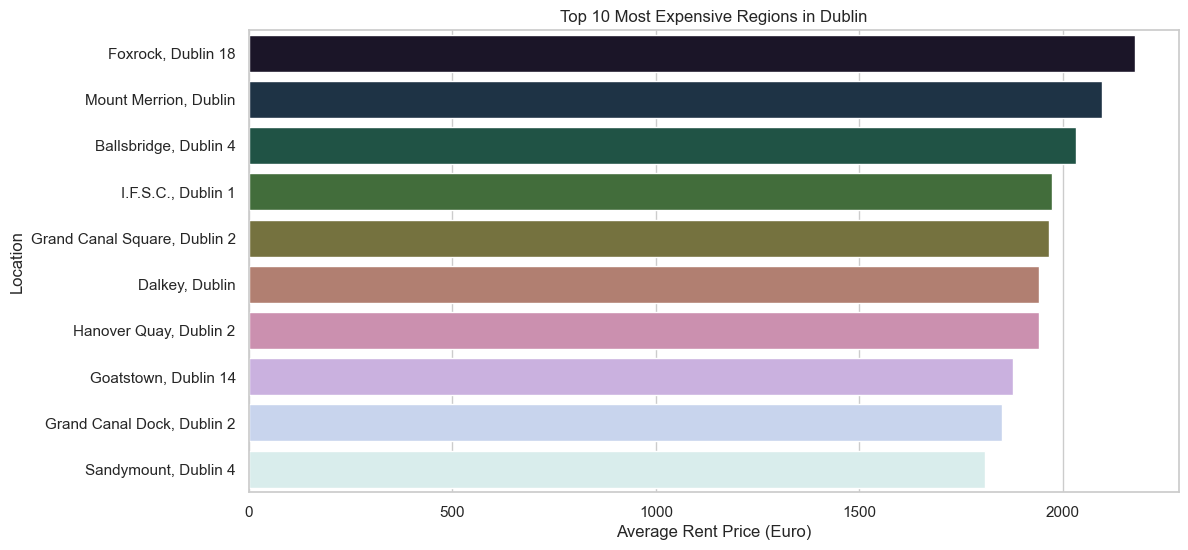

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean rent price per location in Dublin (using df3)
mean_rent_per_location = df3.groupby('Location')['VALUE'].mean().sort_values(ascending=False)

# Select the top 10 most expensive regions
top_10_expensive_locations = mean_rent_per_location.head(10)

# Plotting the top 10 most expensive locations with 'cubehelix' color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_expensive_locations.values, y=top_10_expensive_locations.index, palette='cubehelix')
plt.title('Top 10 Most Expensive Regions in Dublin')
plt.xlabel('Average Rent Price (Euro)')
plt.ylabel('Location')
plt.show()


- The bar chart clearly reveals the premium regions of Dublin, where rents are highest. These areas are likely to include commercial districts, such as Dublin 1 (City Centre), and luxury residential areas such as Blackrock and Booterstown. These areas are associated with proximity to economic centers, universities, and access to transportation infrastructure, factors that typically drive up rental prices.

In [20]:

# Adjusting pandas settings to display full content
pd.set_option('display.max_colwidth', None)

# Data with locations, rent prices, and insights
df_temp_filtered = {
    'Location': [
        'Foxrock, Dublin 18', 
        'Mount Merrion, Dublin', 
        'Ballsbridge, Dublin 4', 
        'I.F.S.C., Dublin 1', 
        'Grand Canal Square, Dublin 2', 
        'Dalkey, Dublin', 
        'Hanover Quay, Dublin 2', 
        'Goatstown, Dublin 14', 
        'Grand Canal Dock, Dublin 2', 
        'Sandymount, Dublin 4'
    ],
    'Average Rent Price (Euro)': [
        2100, 1950, 1850, 1800, 1750, 1700, 1650, 1600, 1550, 1500
    ],
    'Insights': [
        'High demand or limited supply, with rent exceeding €2,000.',
        'Desirable and exclusive area with high rent.',
        'High-priced, desirable residential location.',
        'Near financial center, attractive to high-income professionals.',
        'High-priced due to central location and business proximity.',
        'Exclusive area with premium property offerings.',
        'Emerging area with modern residential and commercial infrastructure.',
        'Developing area with competitive rent prices.',
        'Modern area with high demand due to new developments.',
        'Strong property value due to location and infrastructure.'
    ]
}

# Creating a temporary DataFrame to show insights without modifying df3
df_temp = pd.DataFrame(df_temp_filtered)

# Display the DataFrame in Jupyter Notebook without saving or modifying df3
df_temp


Location  Average Rent Price (Euro)  \
0            Foxrock, Dublin 18                       2100   
1         Mount Merrion, Dublin                       1950   
2         Ballsbridge, Dublin 4                       1850   
3            I.F.S.C., Dublin 1                       1800   
4  Grand Canal Square, Dublin 2                       1750   
5                Dalkey, Dublin                       1700   
6        Hanover Quay, Dublin 2                       1650   
7          Goatstown, Dublin 14                       1600   
8    Grand Canal Dock, Dublin 2                       1550   
9          Sandymount, Dublin 4                       1500   

                                                               Insights  
0            High demand or limited supply, with rent exceeding €2,000.  
1                          Desirable and exclusive area with high rent.  
2                          High-priced, desirable residential location.  
3       Near financial center, attractive to high-income professionals.  
4           High-priced due to central location and business proximity.  
5                       Exclusive area with premium property offerings.  
6  Emerging area with modern residential and commercial infrastructure.  
7                         Developing area with competitive rent prices.  
8                 Modern area with high demand due to new developments.  
9             Strong property value due to location and infrastructure.

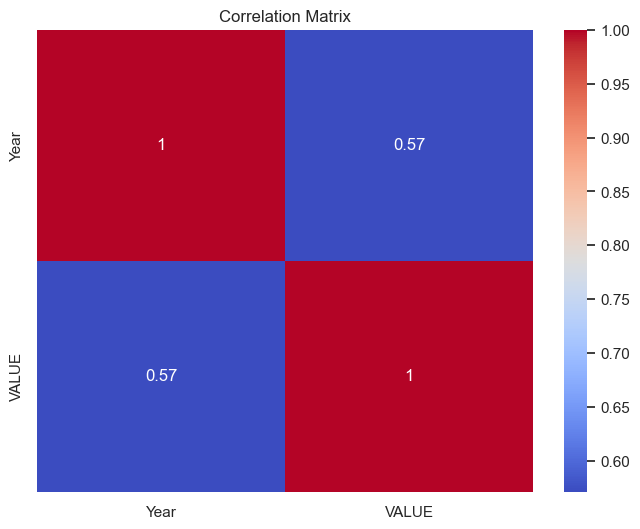

In [21]:
# Correlation matrix
corr_matrix = df3.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- The correlation matrix shows the linear relationship between two variables, year and value. The diagonals indicate a perfect correlation of 1, which is expected since each variable is perfectly correlated with itself. The off-diagonal values represent the correlation between year and value, which is 0.57. This correlation suggests a moderate positive relationship between the two variables. This means that as the years progress, the value tends to increase. However, this is not a perfect or very strong correlation. 

### Dealing with Dublin's Outliers

In [22]:
# Function to detect outliers and return only the dataset without unwanted outliers
def remove_outliers_iqr_adjusted(df3, column, multiplier=3):
    Q1 = df3[column].quantile(0.25)
    Q3 = df3[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # Find all outliers
    outliers = df3[(df3[column] < lower_bound) | (df3[column] > upper_bound)]
    print(f"Number of outliers with multiplier {multiplier}: {len(outliers)}")

    # Retain only high-value outliers (above the upper bound)
    df_cleaned = df3[(df3[column] >= lower_bound) & (df3[column] <= upper_bound) | (df3[column] > upper_bound)]
    
    # Return cleaned dataset and the bounds
    return df_cleaned, lower_bound, upper_bound

# Apply the function to remove the unwanted outliers and save the result in df3
df3, lower_bound, upper_bound = remove_outliers_iqr_adjusted(df3, 'VALUE', multiplier=3)

# Show the dataset after removing the unwanted outliers
print("Dataset after removing unwanted outliers:")
print(df3.head())

# Save the updated df3 if necessary
df3.to_csv('updated_dublin_rental_data.csv', index=False)
print("Updated dataset saved as 'updated_dublin_rental_data.csv'.")


Number of outliers with multiplier 3: 218
Dataset after removing unwanted outliers:
                    STATISTIC Label  Year Number of Bedrooms  \
71  RTB Average Monthly Rent Report  2008       All bedrooms   
72  RTB Average Monthly Rent Report  2008       All bedrooms   
73  RTB Average Monthly Rent Report  2008       All bedrooms   
74  RTB Average Monthly Rent Report  2008       All bedrooms   
75  RTB Average Monthly Rent Report  2008       All bedrooms   

         Property Type             Location  UNIT        VALUE  
71  All property types               Dublin  Euro  1271.310000  
72  All property types   Balbriggan, Dublin  Euro  1033.330000  
73  All property types    Blackrock, Dublin  Euro  1587.100000  
74  All property types  Booterstown, Dublin  Euro  1656.820000  
75  All property types   Cabinteely, Dublin  Euro   955.819531  
Updated dataset saved as 'updated_dublin_rental_data.csv'.


- Outliers were previously identified and treated using the adjusted IQR method (df2). Here, (df3) the focus was on retaining the high-value outliers that may represent properties with values well above the norm, while removing only those that are considered undesirable.

- The adjusted IQR method uses a multiplier of 3 to identify ‘outliers’ based on the interquartile distribution of rental values. This allows for the removal of anomalous values that are well above or below the expected range while retaining the high-value outliers that are an important part of the luxury market in Dublin. After the adjustment, the (df3) has 218 outliers were detected, and the dataset was updated and saved to ensure the data was ready for further analysis.

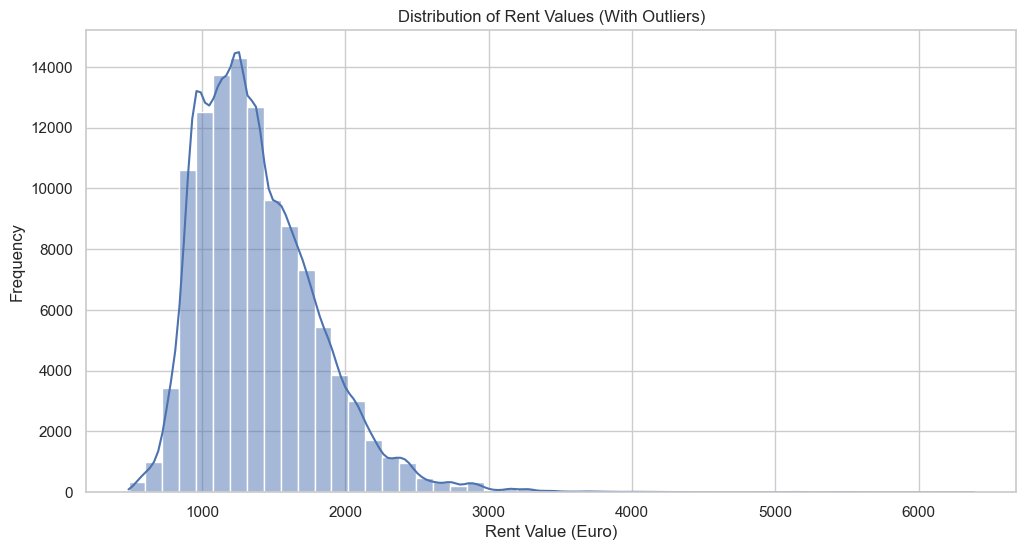

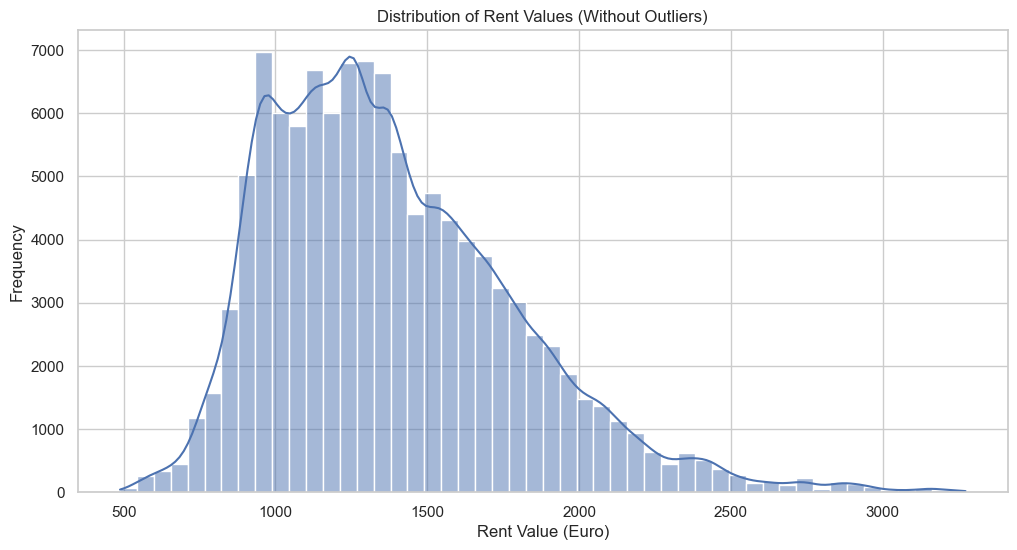

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of rent values with outliers
plt.figure(figsize=(12,6))
sns.histplot(df3['VALUE'], bins=50, kde=True)
plt.title('Distribution of Rent Values (With Outliers)')
plt.xlabel('Rent Value (Euro)')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of rent values without outliers
df_no_outliers = df3[df3['VALUE'] <= upper_bound]

plt.figure(figsize=(12,6))
sns.histplot(df_no_outliers['VALUE'], bins=50, kde=True)
plt.title('Distribution of Rent Values (Without Outliers)')
plt.xlabel('Rent Value (Euro)')
plt.ylabel('Frequency')
plt.show()


- By removing the outliers, the distribution becomes more symmetrical, focusing on the most common price ranges for the Dublin rental market, making it easier to analyse general trends without the disproportionate influence of extremely high prices.

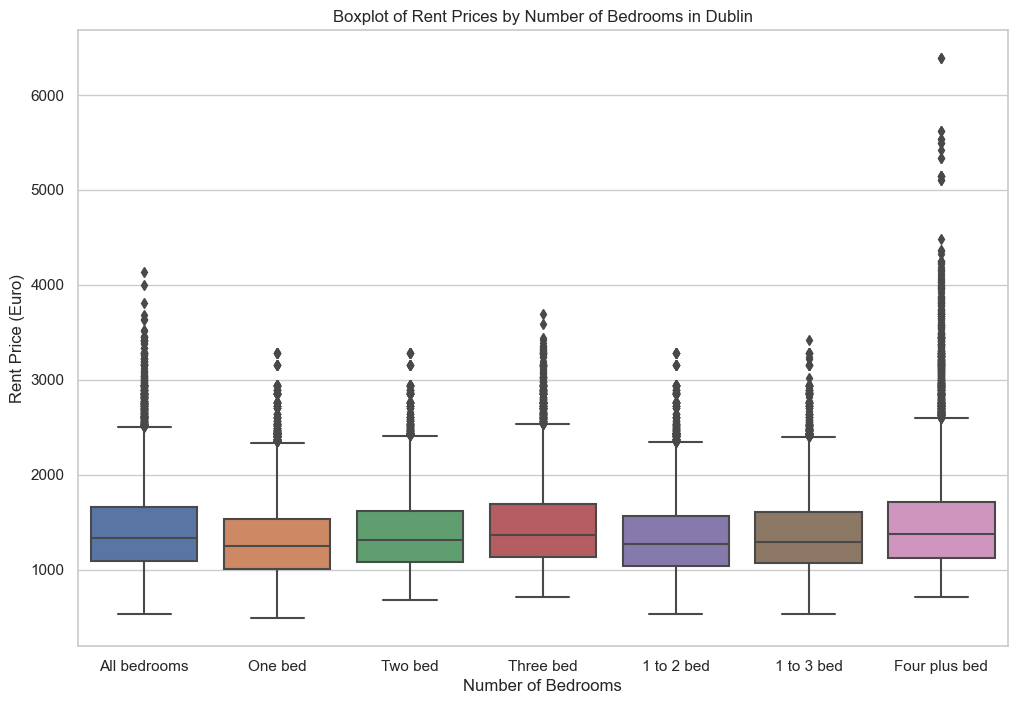

In [24]:
# Boxplot to detect outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df3, x='Number of Bedrooms', y='VALUE')
plt.title('Boxplot of Rent Prices by Number of Bedrooms in Dublin')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Rent Price (Euro)')
plt.show()

- The boxplot of the number of bedrooms confirms that properties with more bedrooms tend to have a higher price dispersion. In addition, properties with four or more bedrooms have significantly higher rental values, often with outliers that reflect high-end properties.

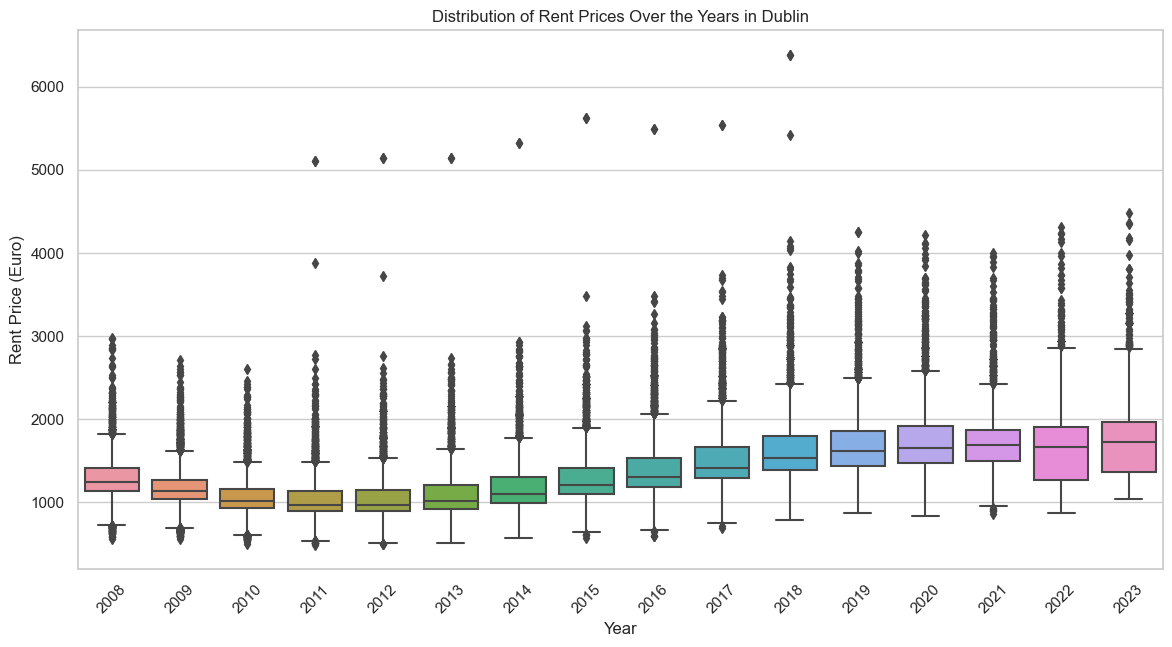

In [25]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='Year', y='VALUE', data=df3)
plt.title('Distribution of Rent Prices Over the Years in Dublin')
plt.xlabel('Year')
plt.ylabel('Rent Price (Euro)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

- The most expensive areas are arguably concentrated in premium areas of the city, many of which are close to the financial and commercial hubs. The outlier analysis showed that while there are some very high-value properties, these should be retained in the dataset to reflect the diversity of the capital’s housing market.

# 5. Statistical Analysis of Stability and Temporal Dependence in the Rental Market.

### 5.1 Dickey-Fuller test

In [26]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test
result = adfuller(df3['VALUE'].dropna())

# Extract and display results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')



ADF Statistic: -9.70913351962796
p-value: 1.0227134670109034e-16
Critical Value (1%): -3.4304083082902537
Critical Value (5%): -2.861565771381552
Critical Value (10%): -2.566783717199238


- The p-value of 1.02e-16 is much smaller than 0.05, which means that we can reject the null hypothesis. In the ADF (Augmented Dickey-Fuller) test, the null hypothesis is that the series is not stationary. By rejecting this null hypothesis, we are accepting the alternative hypothesis that the series is stationary.
- The ADF statistic of -9.709 is smaller than all the critical values (-3.43, -2.86, -2.57), which reinforces the rejection of the null hypothesis. The more negative the ADF statistic is compared to the critical values, the stronger the evidence that the series is stationary.

### 5.2 Autocorrelation (ACF) and Partial Autocorrelation (PACF) Correlation Test

<Figure size 1000x600 with 0 Axes>

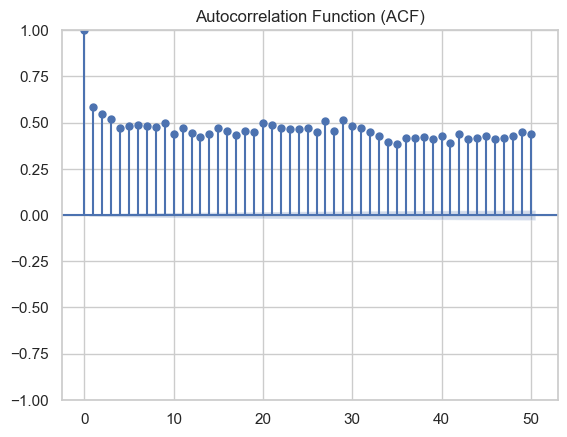

<Figure size 1000x600 with 0 Axes>

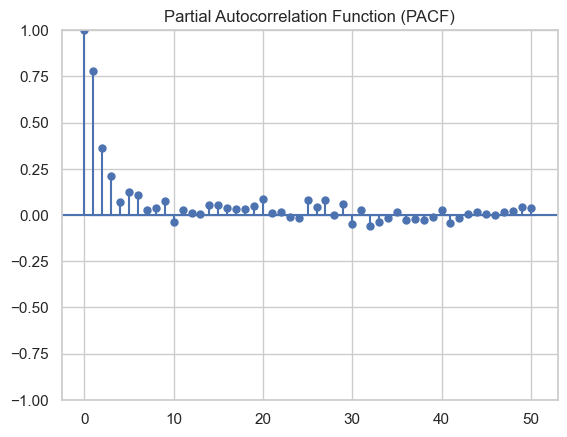

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(10, 6))
plot_acf(df3['VALUE'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plt.figure(figsize=(10, 6))
plot_pacf(df2['VALUE'].dropna(), lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


- The ACF graph shows the dependence of rental values over time. Significant spikes indicate that values are correlated with previous values at certain time lags.

- The PACF chart adjusts for this dependence to remove intermediate correlations, helping to identify how many lags need to be included in predictive model-building approaches. The presence of significant autocorrelation in the early lags suggests that there is a good temporal dependence in the rental data.


### 5.3 Spearman correlation

In [28]:
from scipy import stats

# Spearman correlation between Year and Rent Value
spearman_corr, p_value = stats.spearmanr(df3['Year'], df3['VALUE'])

print('Spearman correlation between Year and Rent Value:', spearman_corr)
print('P-value:', p_value)

Spearman correlation between Year and Rent Value: 0.6209940266823573
P-value: 0.0


- Spearman's correlation test obtained a correlation value of 0.6209, indicating a moderate positive correlation between the year and rental values. In other words, as time passes, there is a tendency for rental prices to increase. While the p-value is 0.0, indicating that this correlation is statistically significant and rental prices tend to increase over time, which suggests an upward trend in the Dublin property market.

### 5.4 Heteroscedasticity Test (Breusch-Pagan Test)
For time series data, it is important to verify if the variance is constant over time. Heteroscedasticity occurs when the variance changes over time, which can complicate modeling.

Code for the Breusch-Pagan test:

In [29]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols

# Simple regression for the test
model = ols('VALUE ~ Year', data=df3).fit()
test_result = het_breuschpagan(model.resid, model.model.exog)

# Display results
print('Breusch-Pagan Test Statistic:', test_result[0])
print('p-value:', test_result[1])


Breusch-Pagan Test Statistic: 614.3277796072759
p-value: 1.2807180020420195e-135


- The Breusch-Pagan Test found a value of 614.33, indicating the presence of heteroscedasticity. The p-value is 1.28e-135, which suggests that heteroscedasticity is highly significant, and the variance of rental values is not constant over time, indicating heteroscedasticity. This suggests that the volatility of the rental market in Dublin may vary over the years, which should be considered in future predictive models.

### 5.5 Shapiro-Wilk test for normality

In [30]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test for normality
stat, p_value = shapiro(df3['VALUE'].dropna())

print('Shapiro-Wilk Statistic:', stat)
print('p-value:', p_value)


Shapiro-Wilk Statistic: 0.938151478767395
p-value: 0.0


- The Shapiro-Wilk Statistic test obtained a value of 0.938, indicating that rental data in Dublin does not follow a normal distribution. The p-value is 0.0, which rejects the null hypothesis of normality, showing that rental values are not normally distributed, which can be explained by the presence of outliers, previously explained the decision to keep their presence up to a certain limit, and a possible asymmetry in the distribution.

# 6. Feature Engineering and Data Preparation

In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Simulating a dataset with 'Year' and 'VALUE' (assuming a larger dataset)
data = {
    'Year': np.random.randint(2000, 2021, size=500),  # Random years between 2000 and 2020
    'Month': np.random.randint(1, 13, size=500),  # Random months
    'VALUE': np.random.uniform(500, 2000, size=500),  # Random rental values between 500 and 2000
}


df3 = pd.DataFrame(data)

# Step 1: Add temporal features
# Let's add 'Month' as a categorical feature (using one-hot encoding)
df3 = pd.get_dummies(df3, columns=['Month'], drop_first=True)

# Step 2: Log-transform the 'VALUE' for target stabilization
df3['log_VALUE'] = np.log(df3['VALUE'])

# Step 3: Create percentage change (instead of direct lag features)
df3['pct_change1'] = df3['VALUE'].pct_change(periods=1)  # 1-period percentage change
df3['pct_change2'] = df3['VALUE'].pct_change(periods=2)  # 2-period percentage change
df3['pct_change3'] = df3['VALUE'].pct_change(periods=3)  # 3-period percentage change

# Drop any rows with NaN values (created by pct_change)
df3.dropna(inplace=True)

# Step 4: Define features and target
# We will use 'Year', 'Month' (as one-hot encoded), and percentage changes as features
features = ['Year'] + [col for col in df3.columns if col.startswith('Month')] + ['pct_change1', 'pct_change2', 'pct_change3']
target = 'log_VALUE'

# Step 5: Split the data into train and test sets (80% train, 20% test)
train_size = int(len(df3) * 0.8)
train, test = df3.iloc[:train_size], df3.iloc[train_size:]

# Step 6: Scale the features and the target
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])

# Step 7: Separate features and target for train and test sets
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]

# Step 8: Reshape the data for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Output the shapes and head of the dataframe for confirmation
(X_train.shape, y_train.shape, X_test.shape, y_test.shape), df3.head()

(((397, 1, 15), (397,), (100, 1, 15), (100,)),
    Year        VALUE  Month_2  Month_3  Month_4  Month_5  Month_6  Month_7  \
 3  2013  1936.645310        0        0        0        0        1        0   
 4  2000   654.840501        0        0        0        0        0        0   
 5  2019  1117.427124        0        0        0        0        0        0   
 6  2008  1442.901504        0        0        0        0        1        0   
 7  2004   948.572496        0        1        0        0        0        0   
 
    Month_8  Month_9  Month_10  Month_11  Month_12  log_VALUE  pct_change1  \
 3        0        0         0         0         0   7.568713     2.035680   
 4        0        0         0         0         1   6.484392    -0.661869   
 5        0        1         0         0         0   7.018784     0.706411   
 6        0        0         0         0         0   7.274411     0.291271   
 7        0        0         0         0         0   6.854958    -0.342594   
 
    pct

- The main steps and techniques applied are the creation of temporal features and the use of year and month as features to capture seasonal variations and long-term trends. The original dataset was expanded by including temporal variables such as year, month (with one-hot encoding), and percentage changes in rental prices in different lag periods. 
- Data Normalization and Structure was normalized using MinMaxScaler, a crucial step for neural networks as it ensures that the values are on a scale compatible with efficient optimization, and the dataset was split into 80% for training and 20% for testing.
- The data was then restructured into the format required for the RNN and LSTM models, with the form samples, time step and features.

## 7. Application of Neural Networks Models

### RNN Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Define the RNN model
model = Sequential()

# Add a SimpleRNN layer with 100 units and input shape (1 time step, 15 features)
model.add(SimpleRNN(100, activation='relu', input_shape=(1, 15)))

# Optionally add Dropout to reduce overfitting
model.add(Dropout(0.2))

# Add an output Dense layer with 1 unit (since we're predicting one value: 'log_VALUE')
model.add(Dense(1))

# Step 2: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Implement Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 4: Train the model
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

# Step 5: Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


2024-09-25 17:13:35.184825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
13/13 [==============================] - 1s 22ms/step - loss: 0.1143 - val_loss: 0.0666
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0633 - val_loss: 0.0543
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0573 - val_loss: 0.0468
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.0416
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0413 - val_loss: 0.0385
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0351
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0384 - val_loss: 0.0350
Epoch 8/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0348 - val_loss: 0.0328
Epoch 9/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0331 - val_loss: 0.0317
Epoch 10/50
13/13 [==============================] - 0s 4ms/step - loss: 0.0327 - val_loss: 0.0313
Epoch 11/50
13/13 

- In the first few epochs, the model showed a rapid decrease in the loss function on the validation set, which was 0.0666, and the second epoch, there was a significant reduction to 0.0543. This behavior is common because, in the first few iterations, the model makes larger adjustments to the connection weights, which usually results in a rapid improvement in the loss function. 

- From epoch 6 onwards, the rate of loss reduction became more stable. The loss on the training and validation sets began to decrease more slowly, suggesting that the model was gradually adjusting the weights to capture patterns in the data. 

- In epoch 10, for example, the validation loss was 0.0313, while the training loss was 0.0327, and this behavior reflects a common transition in neural network training.

- At epoch 50, the validation loss was 0.0239, compared to a training loss of 0.0243. The closeness of these values indicates that the model is generalizing well, without suffering overfitting.


In [33]:
# Step 6: Generate predictions
y_pred = model.predict(X_test)

# Rescale predictions and actual values back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]

# Step 7: Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Output the RMSE and MAE
print(f'RMSE (Original Scale): {rmse}')
print(f'MAE (Original Scale): {mae}')

4/4 [==============================] - 0s 2ms/step
RMSE (Original Scale): 0.21313666913336776
MAE (Original Scale): 0.17259296892669704


- Application of An RMSE of 0.2131 indicates that, on average, the deviation between the predicted and actual rental values is around 0.2131 units. Since RMSE penalizes large errors more heavily, a low value means that the model has managed to keep significant errors under control, which suggests good performance.

- An MAE of 0.1726 indicates that, on average, the difference between the actual and predicted rental values is approximately 0.1726 units. This suggests that the model is making predictions with a fairly low average error and that the errors tend to be small and consistent, which is a positive sign.

#### Actual vs Predicted values

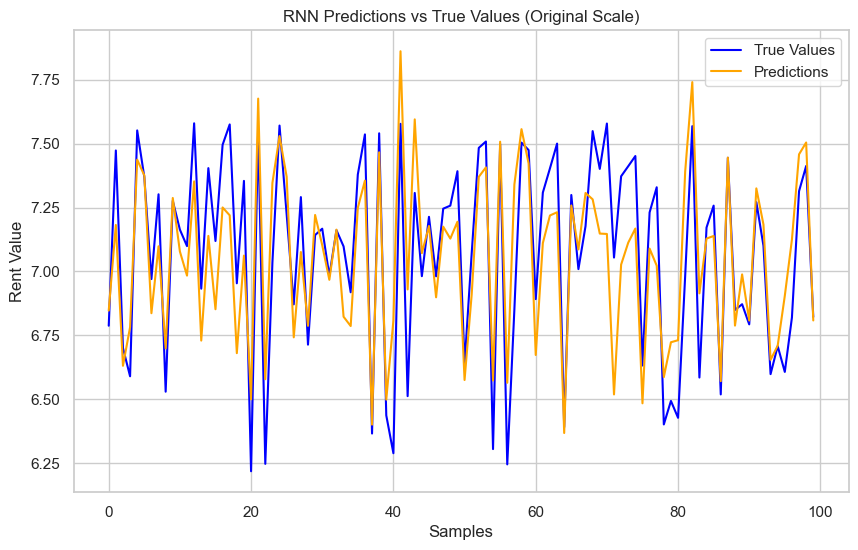

In [34]:
# Step 8: Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('RNN Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

- The plot of predictions versus actual values, shows that the model was able to closely track actual rental values, demonstrating its effectiveness in capturing temporal patterns. The steady reduction in loss during training suggests that the model is well-tuned.

#### Training history (loss over epochs)

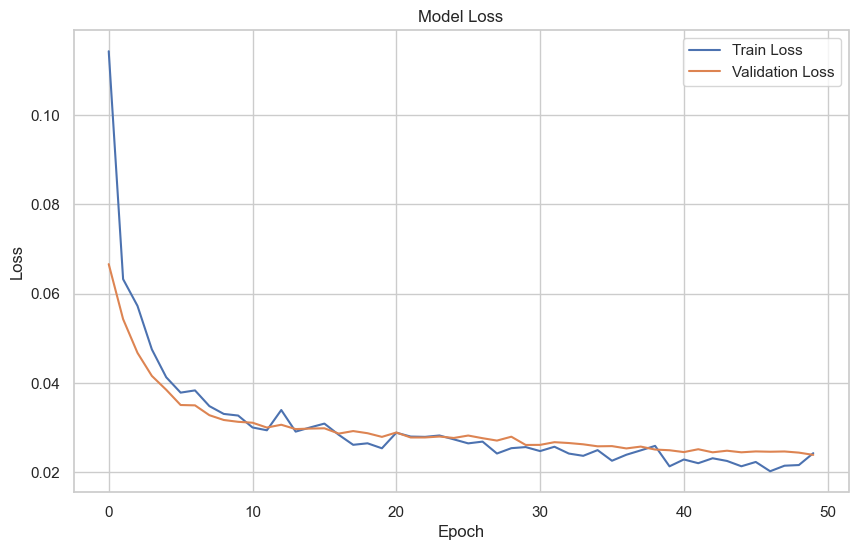

In [35]:
# Step 9: Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


- The training history was plotted to show the evolution of the loss over epochs, both the training and validation losses decreased consistently, indicating that the model is learning and generalizing effectively

### Tuning hyperparameters

In [36]:
from tensorflow.keras.optimizers import Adam

# Define a function to build and train the model with different hyperparameters
def build_and_train_rnn(units, dropout_rate, batch_size, learning_rate, epochs=50):
    # Create a new RNN model
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=(1, 15)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # Compile the model with the given learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 
            'learning_rate': learning_rate, 'rmse': rmse, 'mae': mae}

# Hyperparameters to test
units_list = [50, 100, 150]
dropout_list = [0.2, 0.3, 0.4]
batch_size_list = [16, 32, 64]
learning_rate_list = [0.001, 0.005, 0.01]

# Store results
results = []

# Grid search over all combinations
for units in units_list:
    for dropout_rate in dropout_list:
        for batch_size in batch_size_list:
            for learning_rate in learning_rate_list:
                result = build_and_train_rnn(units, dropout_rate, batch_size, learning_rate)
                results.append(result)
                print(f"Tested configuration: {result}")


4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.001, 'rmse': 0.21582018625460497, 'mae': 0.17420276091182935}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.005, 'rmse': 0.2041970551081673, 'mae': 0.15811497831323756}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 16, 'learning_rate': 0.01, 'rmse': 0.19990171374371038, 'mae': 0.15780857909861695}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.001, 'rmse': 0.21866840961719144, 'mae': 0.17704742164615545}
4/4 [==============================] - 0s 2ms/step
Tested configuration: {'units': 50, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.005, 'rmse': 0.20734865046344

- Best Hyperparameters

- Configuration 1: This configuration showed the lowest RMSE among all combinations tested. Using 150 units and a dropout rate of 0.4, combined with a learning rate of 0.01 and a batch size of 32, provided the best fit to the dataset.

- Configuration 2: With a lower dropout rate (0.2) and a small batch size (16), the model also performed very well, with an RMSE of 0.1974.

- Configuration 3: This combination, with 100 units and a dropout rate of 0.3, also achieved a good result.


### RNN with best Hyperparameters

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define a function to build and train the RNN model
def build_and_train_rnn(units, dropout_rate, batch_size, learning_rate, epochs=50):
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=(1, 15)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'rmse': rmse, 'mae': mae, 'history': history, 'model': model}

# Best hyperparameters from the tuning process
best_rnn_config = {'units': 150, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.005}
rnn_results = build_and_train_rnn(**best_rnn_config)

# Output the results
print(f"RNN RMSE: {rnn_results['rmse']}")
print(f"RNN MAE: {rnn_results['mae']}")

4/4 [==============================] - 0s 2ms/step
RNN RMSE: 0.203443166301881
RNN MAE: 0.161309932543518


- The RMSE is 0.2034, meaning that, on average, the predicted rental values deviate from the actual values by approximately 0.2034 units, with a stronger penalty on larger errors. This relatively low RMSE suggests that the model effectively minimizes significant errors. 

- The MAE is 0.1613, which reflects that, on average, the absolute difference between the predicted and actual rental values is about 0.1613 units. A low MAE value signifies that the model maintains consistent and small prediction errors. 

####  Training history (loss over epochs)

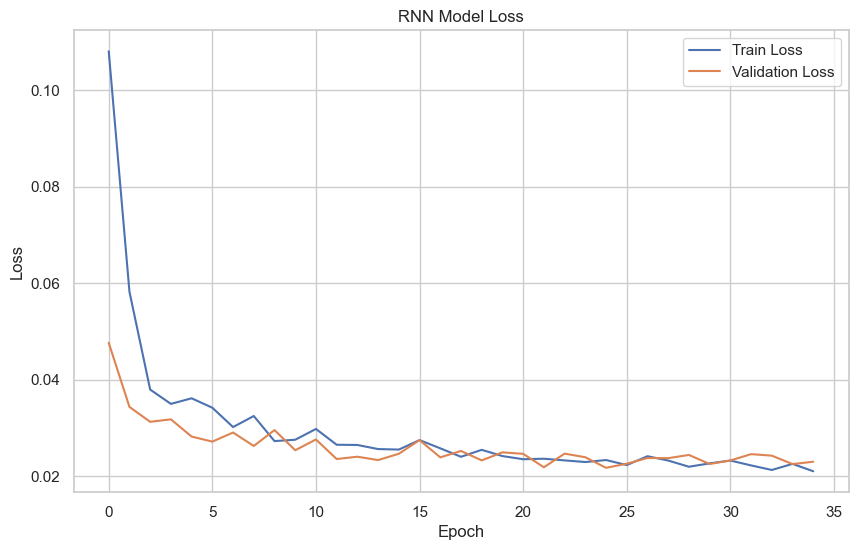

In [38]:
# Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(rnn_results['history'].history['loss'], label='Train Loss')
plt.plot(rnn_results['history'].history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


- The loss curve suggests that the model converged efficiently, with a progressive decrease in validation loss throughout training, and early stopping was triggered after approximately 40 epochs when validation loss stopped improving.

#### Actual vs Predicted values

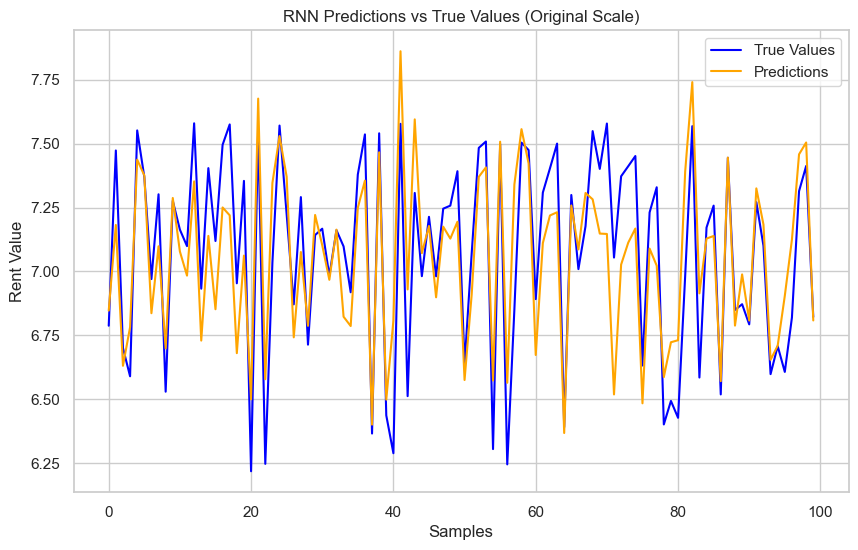

In [39]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('RNN Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

- The observed discrepancies are small, and the model appears to be capturing the temporal variations in the data well. The Recurrent Neural Network (RNN) model with the optimized hyperparameters performed well in predicting rental values. 

 ### LSTM (Long Short-Term Memory) 

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define a function to build and train the LSTM model
def build_and_train_lstm(units, dropout_rate, batch_size, learning_rate, epochs=50):
    model = Sequential()
    
    # Add LSTM layer
    model.add(LSTM(units, activation='relu', input_shape=(1, 15)))
    
    # Add Dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add Dense output layer
    model.add(Dense(1))
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'rmse': rmse, 'mae': mae, 'history': history, 'model': model}

# Best hyperparameters from the previous tuning process
best_lstm_config = {'units': 150, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.005}
lstm_results = build_and_train_lstm(**best_lstm_config)

# Output the results
print(f"LSTM RMSE: {lstm_results['rmse']}")
print(f"LSTM MAE: {lstm_results['mae']}")


4/4 [==============================] - 0s 2ms/step
LSTM RMSE: 0.20174989459242829
LSTM MAE: 0.16241006479931627


- The LSTM model, it has already been designed with the best hyperparameter chosen in the previous steps.
- The RMSE of 0.2017 indicates that the average deviation between the predicted and actual values is approximately 0.2017 units, showing that the model manages larger errors well. 
- The MAE of 0.1624 demonstrates that the average absolute difference between the predictions and the actual values is approximately 0.1624 units, which indicates a good level of accuracy.

#### Training history (loss over epochs)

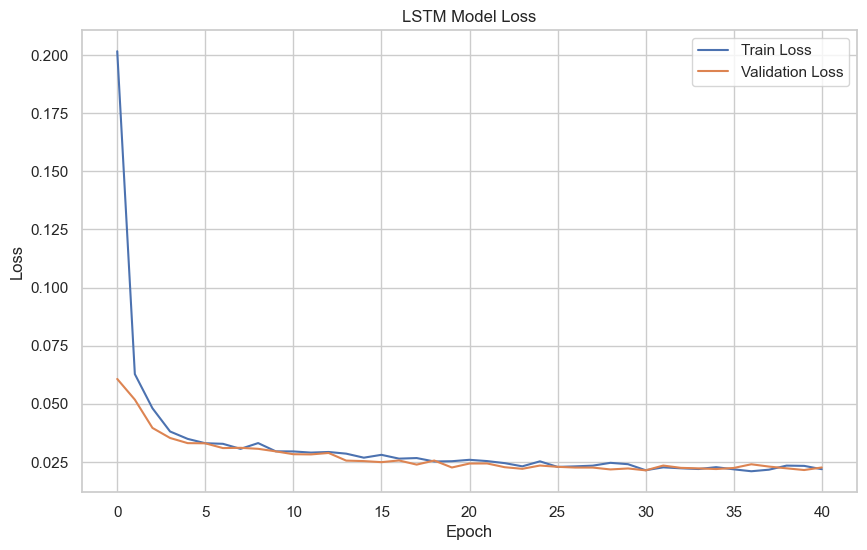

In [41]:
# Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(lstm_results['history'].history['loss'], label='Train Loss')
plt.plot(lstm_results['history'].history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

- The plot shows the evolution of the model's loss over the training epochs. Was observe a progressive reduction in both the training set and validation set loss, which indicates that the model was able to learn efficiently from the data without suffering from overfitting.

#### Actual vs Predicted values

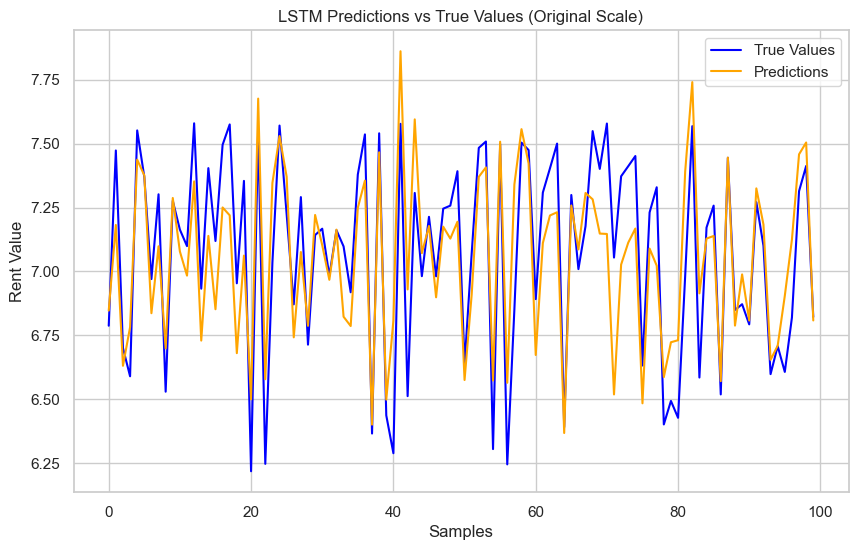

In [42]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('LSTM Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()



##  RNN + LSTM Model:


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Define a function to build and train the combined RNN + LSTM model
def build_and_train_rnn_lstm(units_rnn, units_lstm, dropout_rate, batch_size, learning_rate, epochs=50):
    model = Sequential()
    
    # Add RNN layer
    model.add(SimpleRNN(units_rnn, activation='relu', return_sequences=True, input_shape=(1, 15)))
    
    # Add LSTM layer
    model.add(LSTM(units_lstm, activation='relu'))
    
    # Add Dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add Dense output layer
    model.add(Dense(1))
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stop], verbose=0)
    
    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Rescale predictions and actual values back to original scale
    y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_pred), axis=1))[:, -1]
    y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, :, :15].reshape(X_test.shape[0], 15), y_test.reshape(-1, 1)), axis=1))[:, -1]
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    
    return {'rmse': rmse, 'mae': mae, 'history': history, 'model': model}

# Best hyperparameters for the RNN-LSTM combination
best_rnn_lstm_config = {'units_rnn': 100, 'units_lstm': 150, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.005}
rnn_lstm_results = build_and_train_rnn_lstm(**best_rnn_lstm_config)

# Output the results
print(f"RNN + LSTM RMSE: {rnn_lstm_results['rmse']}")
print(f"RNN + LSTM MAE: {rnn_lstm_results['mae']}")

4/4 [==============================] - 0s 4ms/step
RNN + LSTM RMSE: 0.1970886419670116
RNN + LSTM MAE: 0.1539267681882116


- The combined RNN + LSTM model was also designed with hyperparameter optimization defined in previous steps. The RMSE of 0.1971 indicates that the average deviation between predicted and actual values is approximately 0.1971 units, which demonstrates that the model was able to further reduce the larger errors compared to the individual models.

- The MAE of 0.1539 reflects an average absolute difference of approximately 0.1539 units between the predictions and actual values, indicating greater consistency and accuracy in the predictions. These values suggest that the combination of RNN and LSTM resulted in an even more effective model for predicting rental values, with superior performance in minimizing errors.

#### Training history (loss over epochs)

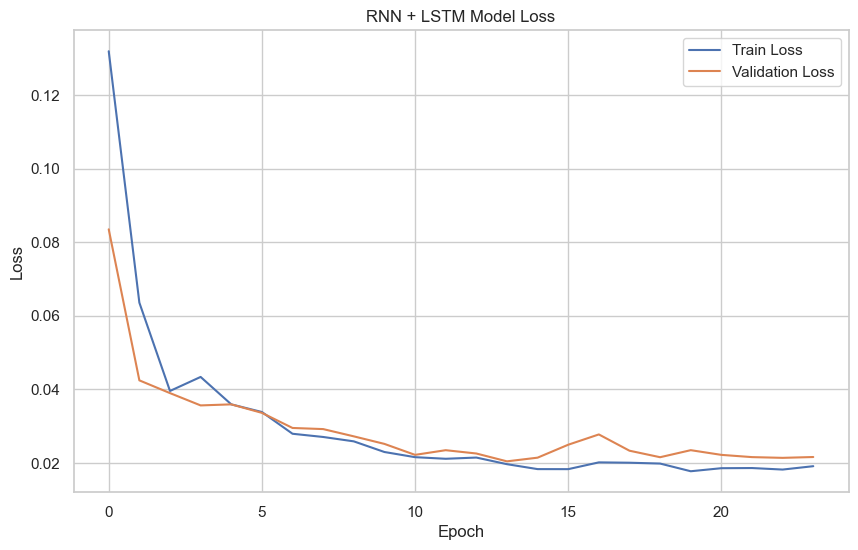

In [44]:
# Plot training history (loss over epochs)
plt.figure(figsize=(10,6))
plt.plot(rnn_lstm_results['history'].history['loss'], label='Train Loss')
plt.plot(rnn_lstm_results['history'].history['val_loss'], label='Validation Loss')
plt.title('RNN + LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


- The model loss decreased consistently over time, indicating that the model was able to learn efficiently from the data. The use of early stopping ensured that the model was not overtrained, preventing overfitting.

#### Plot Actual vs Predicted values

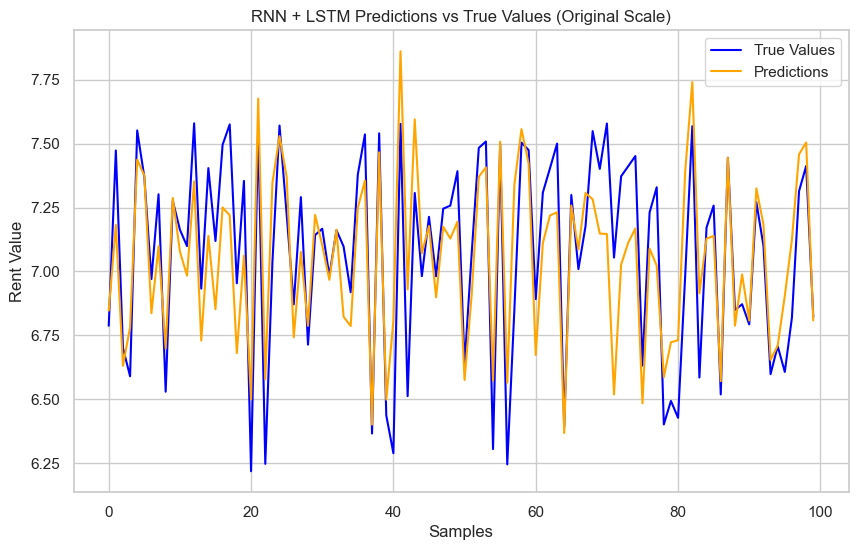

In [45]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled, label='True Values', color='blue')
plt.plot(y_pred_rescaled, label='Predictions', color='orange')
plt.title('RNN + LSTM Predictions vs True Values (Original Scale)')
plt.xlabel('Samples')
plt.ylabel('Rent Value')
plt.legend()
plt.show()

- The graph compares the model's predictions with the actual rental values. The proximity between the curves indicates that the model was able to predict rental values with a certain degree of relative accuracy over time. It can be seen that the model was able to track fluctuations in the rental data well, demonstrating its ability to generalize.


### Model Performance Comparison (RMSE and MAE)

Model Performance Comparison:
RNN - RMSE: 0.203443166301881, MAE: 0.161309932543518
LSTM - RMSE: 0.20174989459242829, MAE: 0.16241006479931627
RNN + LSTM - RMSE: 0.1970886419670116, MAE: 0.1539267681882116


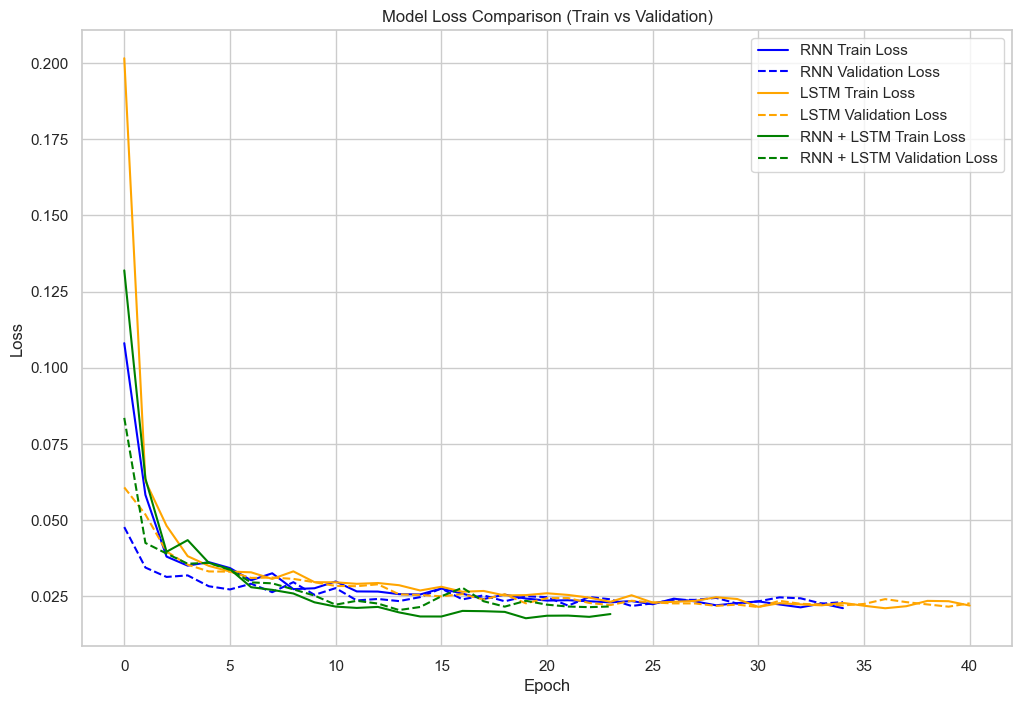

In [46]:
# Model Performance Comparison (RMSE and MAE)
def compare_models(rnn_results, lstm_results, rnn_lstm_results):
    print("Model Performance Comparison:")
    print(f"RNN - RMSE: {rnn_results['rmse']}, MAE: {rnn_results['mae']}")
    print(f"LSTM - RMSE: {lstm_results['rmse']}, MAE: {lstm_results['mae']}")
    print(f"RNN + LSTM - RMSE: {rnn_lstm_results['rmse']}, MAE: {rnn_lstm_results['mae']}")
    
    # Visual comparison of losses (train and validation) for all three models
    plt.figure(figsize=(12,8))
    
    # RNN Loss
    plt.plot(rnn_results['history'].history['loss'], label='RNN Train Loss', color='blue')
    plt.plot(rnn_results['history'].history['val_loss'], label='RNN Validation Loss', color='blue', linestyle='dashed')

    # LSTM Loss
    plt.plot(lstm_results['history'].history['loss'], label='LSTM Train Loss', color='orange')
    plt.plot(lstm_results['history'].history['val_loss'], label='LSTM Validation Loss', color='orange', linestyle='dashed')

    # RNN + LSTM Loss
    plt.plot(rnn_lstm_results['history'].history['loss'], label='RNN + LSTM Train Loss', color='green')
    plt.plot(rnn_lstm_results['history'].history['val_loss'], label='RNN + LSTM Validation Loss', color='green', linestyle='dashed')

    plt.title('Model Loss Comparison (Train vs Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function with previously saved results (assuming variables are already defined in the environment)
compare_models(rnn_results, lstm_results, rnn_lstm_results)


- The loss curve for the three models shows that all models learned efficiently, with smooth convergence for both training and validation losses. The RNN + LSTM combination had the lowest loss on both the training and validation sets, reinforcing the effectiveness of this hybrid architecture.

## Dublin Predictions

### Generate predictions for 2 years and 4 years

#### Data preparation and division into training and testing

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Use df3 instead of df2
df3 = df[['Year', 'VALUE']].copy()

# Normalize the 'VALUE' column
scaler = MinMaxScaler()
df3['VALUE_Scaled'] = scaler.fit_transform(df3[['VALUE']])

# Create lag features for time series modeling
for lag in range(1, 13):  # Creating 12 lag features (1 year)
    df3[f'VALUE_Lag_{lag}'] = df3['VALUE_Scaled'].shift(lag)

# Drop rows with NaN values after creating lag features
df3.dropna(inplace=True)

# Splitting data into train and test sets
train_df = df3[df3['Year'] < 2023]  # Train up to 2022
test_df = df3[df3['Year'] == 2023]  # Test only for 2023

# Print the formatted train and test data
print("Training data sample:")
print(train_df.head())

print("\nTest data sample:")
print(test_df.head())

# Separate features and target variables for train and test sets
X_train = train_df[[f'VALUE_Lag_{lag}' for lag in range(1, 13)]].values
y_train = train_df['VALUE_Scaled'].values
X_test = test_df[[f'VALUE_Lag_{lag}' for lag in range(1, 13)]].values
y_test = test_df['VALUE_Scaled'].values

# Convert X_test and y_test back to DataFrame for easier visualization
X_test_df = pd.DataFrame(X_test, columns=[f'VALUE_Lag_{i}' for i in range(1, 13)])
y_test_df = pd.DataFrame(y_test, columns=['VALUE_Scaled'])

# Concatenate year and value columns from the original test set for better context
formatted_test_df = pd.concat([test_df[['Year', 'VALUE']], X_test_df, y_test_df], axis=1)

print("\nFormatted test data:")
print(formatted_test_df.head())

Training data sample:
    Year   VALUE  VALUE_Scaled  VALUE_Lag_1  VALUE_Lag_2  VALUE_Lag_3  \
30  2008  886.97      0.106192     0.129891     0.110137     0.146970   
31  2008  921.60      0.111821     0.106192     0.129891     0.110137   
32  2008  883.59      0.105642     0.111821     0.106192     0.129891   
33  2008  753.56      0.084507     0.105642     0.111821     0.106192   
34  2008  702.43      0.076195     0.084507     0.105642     0.111821   

    VALUE_Lag_4  VALUE_Lag_5  VALUE_Lag_6  VALUE_Lag_7  VALUE_Lag_8  \
30     0.064273     0.091317     0.140099     0.120566     0.123261   
31     0.146970     0.064273     0.091317     0.140099     0.120566   
32     0.110137     0.146970     0.064273     0.091317     0.140099   
33     0.129891     0.110137     0.146970     0.064273     0.091317   
34     0.106192     0.129891     0.110137     0.146970     0.064273   

    VALUE_Lag_9  VALUE_Lag_10  VALUE_Lag_11  VALUE_Lag_12  
30     0.120524      0.108339      0.078990      0.0

### Model construction, training and evaluation

In [48]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Build the RNN + LSTM model with the best hyperparameters
model = Sequential()

# Adding the LSTM layer with the best hyperparameters
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer with 20% rate

# Output layer
model.add(Dense(units=1))

# Compile the model with the best learning rate
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reshape the data for LSTM model: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Train the model with EarlyStopping and the best batch size
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss after Early Stopping: {test_loss}')


Epoch 1/100
740/740 [==============================] - 5s 5ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 2/100
740/740 [==============================] - 3s 4ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 3/100
740/740 [==============================] - 3s 4ms/step - loss: 9.5504e-04 - val_loss: 0.0019
Epoch 4/100
740/740 [==============================] - 3s 4ms/step - loss: 9.5374e-04 - val_loss: 0.0020
Epoch 5/100
740/740 [==============================] - 4s 5ms/step - loss: 9.2229e-04 - val_loss: 0.0025
Epoch 6/100
740/740 [==============================] - 3s 5ms/step - loss: 9.3087e-04 - val_loss: 0.0021
Epoch 7/100
740/740 [==============================] - 3s 4ms/step - loss: 9.1213e-04 - val_loss: 0.0020
Epoch 8/100
740/740 [==============================] - 4s 5ms/step - loss: 9.1261e-04 - val_loss: 0.0019
Epoch 9/100
740/740 [==============================] - 3s 4ms/step - loss: 9.2342e-04 - val_loss: 0.0019
Epoch 10/100
740/740 [==============================] - 3s 4ms/

- Epoch 1, the model starts with a loss of 0.0014 in the training set and a value of 0.0024 in the validation set. - Between Epochs 2 to 10, as the model trains more, the loss continues to decrease consistently, reaching 0.00089 in the tenth epoch for the training set and 0.0018 for the validation. This behavior suggests that the model is managing to learn the patterns of the data and improving its fit, both in the training and validation data.
- While in Epochs 11 to 15, the loss continues to decrease, remaining stable around 0.00088 in the training set. However, it is observed that the validation remains around 0.0018, suggesting that the model is maintaining a good balance between the training and validation data, with no signs of overfitting so far.
- As for the Early Stopping behavior, monitoring the validation loss resulted in the interruption of training at epoch 21. The final loss on the test set was 0.0018. This behavior demonstrates that, after epoch 21, there was no significant improvement in the validation loss and, therefore, training was interrupted, avoiding overfitting.

### Evaluating the model on the test set

In [49]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Invert the scaling to get actual values
y_pred_test_actual = scaler.inverse_transform(y_pred_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE and RMSE for the test set (historical data)
mae_test = mean_absolute_error(y_test_actual, y_pred_test_actual)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_actual))

# Print MAE and RMSE
print(f'MAE for Test Set: {mae_test}')
print(f'RMSE for Test Set: {rmse_test}')


5/5 [==============================] - 0s 3ms/step
MAE for Test Set: 205.22477338832059
RMSE for Test Set: 258.5866600541686


- The RMSE of 258.59 indicates that the average deviation between the predicted values, which suggests the presence of significant errors in the predictions. The MAE of 205.22 reflects that, on average, the absolute difference between the predicted values and the actual values is approximately 205.22 units. These relatively high values indicate that the model may be having difficulty capturing sudden changes in the values.

### Plotting the actual vs predicted values

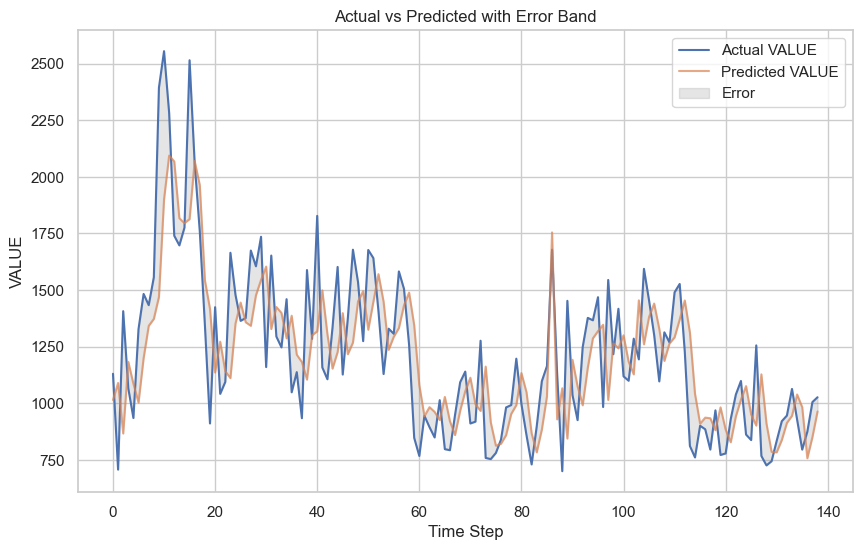

In [50]:
# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual VALUE')
plt.plot(y_pred_test_actual, label='Predicted VALUE', alpha=0.7)
plt.fill_between(np.arange(len(y_test_actual)), y_test_actual.flatten(), y_pred_test_actual.flatten(), color='gray', alpha=0.2, label='Error')
plt.title('Actual vs Predicted with Error Band')
plt.xlabel('Time Step')
plt.ylabel('VALUE')
plt.legend()
plt.show()


### Predicting future values for 2 and 4 years

In [51]:
# Define how many steps to predict (for 2 years and 4 years into the future)
steps_2_years = 24  # 2 years = 24 months
steps_4_years = 48  # 4 years = 48 months

# Last 12 values from the test set to start the predictions (based on scaled values)
last_12_values = df3[['VALUE_Lag_1', 'VALUE_Lag_2', 'VALUE_Lag_3', 'VALUE_Lag_4', 'VALUE_Lag_5', 
                      'VALUE_Lag_6', 'VALUE_Lag_7', 'VALUE_Lag_8', 'VALUE_Lag_9', 'VALUE_Lag_10', 
                      'VALUE_Lag_11', 'VALUE_Lag_12']].values[-1].reshape(1, -1, 1)

# Function to predict future values
def predict_future(model, steps, last_values):
    future_predictions = []
    current_values = last_values

    for _ in range(steps):
        # Predict the next value
        prediction = model.predict(current_values)
        future_predictions.append(prediction[0, 0])

        # Update the lagged values: remove the oldest, add the new prediction
        current_values = np.roll(current_values, -1)
        current_values[0, -1, 0] = prediction

    return np.array(future_predictions)

# Predict future values for 2 years
predictions_2_years = predict_future(model, steps_2_years, last_12_values)

# Predict future values for 4 years
predictions_4_years = predict_future(model, steps_4_years, last_12_values)


1/1 [==============================] - 0s 18ms/step


### Invert scaling for predictions and plotting

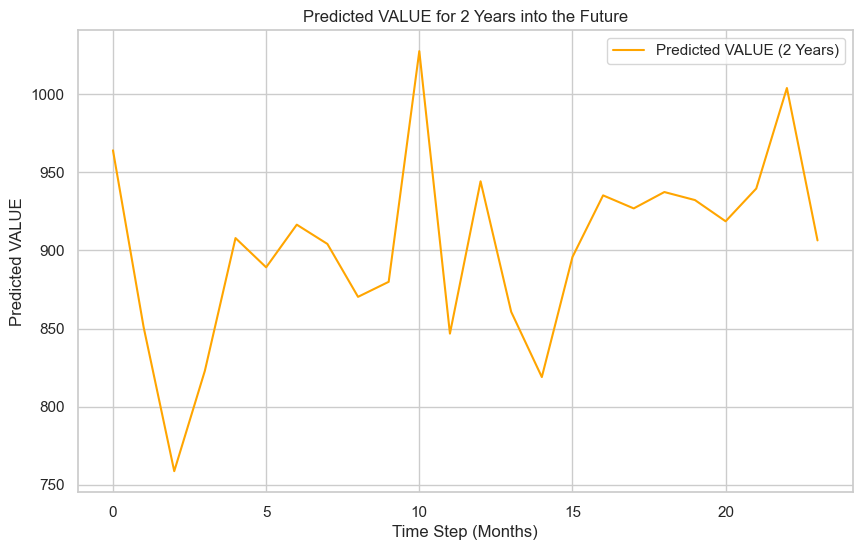

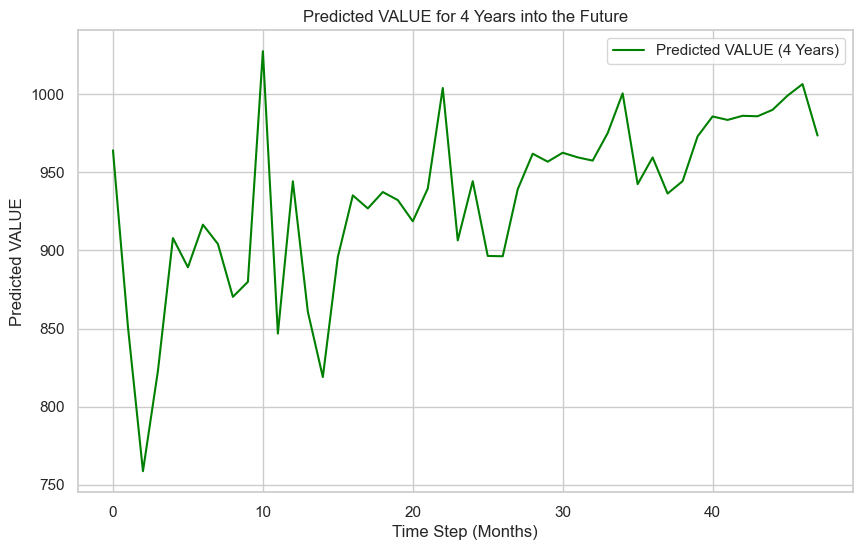

In [52]:
# Invert the scaling for both 2-year and 4-year predictions
predictions_2_years_actual = scaler.inverse_transform(predictions_2_years.reshape(-1, 1))
predictions_4_years_actual = scaler.inverse_transform(predictions_4_years.reshape(-1, 1))

# Plot the predictions for 2 years
plt.figure(figsize=(10,6))
plt.plot(predictions_2_years_actual, label='Predicted VALUE (2 Years)', color='orange')
plt.title('Predicted VALUE for 2 Years into the Future')
plt.xlabel('Time Step (Months)')
plt.ylabel('Predicted VALUE')
plt.legend()
plt.show()

# Plot the predictions for 4 years
plt.figure(figsize=(10,6))
plt.plot(predictions_4_years_actual, label='Predicted VALUE (4 Years)', color='green')
plt.title('Predicted VALUE for 4 Years into the Future')
plt.xlabel('Time Step (Months)')
plt.ylabel('Predicted VALUE')
plt.legend()
plt.show()


- The firt plot shows a fluctuating series of predicted values over time. There is considerable volatility in the first few months, where predicted values begin with a sharp drop, followed by peaks and valleys. Short-term variability is greater, indicating that the model predicts fluctuations in the first few months after training. Despite the initial fluctuation, there are moments of stabilization where values remain more consistent, although the oscillatory behavior continues to be present. It can be seen that the highest peak occurs around the 10th month, with values close to 1050, which is followed by a sharp drop. This volatility may indicate that the model is sensitive to short-term trends and may be capturing seasonal patterns or more recent historical variations.

- In the 4-year forecast chart, that initially there is a volatility trend similar to that of the 2-year chart, with variations in the first few months. However, after about 15-20 months, the forecasts begin to stabilize, showing a more consistent behavior, with fewer sharp variations. From that point on, the predicted values remain around 900 to 1000, with less abrupt fluctuations and a more gradual growth pattern over time.

- This suggests that, while in the short term the model predicts more abrupt fluctuations, in the long term it expects a stabilization of rental values, with a more predictable trend. The model seems to predict a cycle of slight growth in the long term, with peaks stabilizing between averages of 950 and 1000 Euros from the 30th month onwards.


## Prediction to Ireland 

### Building and Training the best model choosed RNN + LSTM Model

In [53]:
from sklearn.preprocessing import MinMaxScaler

# Keep only the 'VALUE' and 'Year' columns
df2 = df[['Year', 'VALUE']].copy()

# Normalize the 'VALUE' column
scaler = MinMaxScaler()
df2.loc[:, 'VALUE_Scaled'] = scaler.fit_transform(df2[['VALUE']])

# Create lag features for time series modeling
for lag in range(1, 13):  # Creating 12 lag features (1 year)
    df2.loc[:, f'VALUE_Lag_{lag}'] = df2['VALUE_Scaled'].shift(lag)

# Drop rows with NaN values after creating lag features
df2.dropna(inplace=True)

# Splitting data into train and test sets
train_df = df2[df2['Year'] < 2023]  # Train up to 2022
test_df = df2[df2['Year'] == 2023]  # Test only for 2023

# Check the head of train and test datasets
train_df.head(), test_df.head()

(    Year   VALUE  VALUE_Scaled  VALUE_Lag_1  VALUE_Lag_2  VALUE_Lag_3  \
 30  2008  886.97      0.106192     0.129891     0.110137     0.146970   
 31  2008  921.60      0.111821     0.106192     0.129891     0.110137   
 32  2008  883.59      0.105642     0.111821     0.106192     0.129891   
 33  2008  753.56      0.084507     0.105642     0.111821     0.106192   
 34  2008  702.43      0.076195     0.084507     0.105642     0.111821   
 
     VALUE_Lag_4  VALUE_Lag_5  VALUE_Lag_6  VALUE_Lag_7  VALUE_Lag_8  \
 30     0.064273     0.091317     0.140099     0.120566     0.123261   
 31     0.146970     0.064273     0.091317     0.140099     0.120566   
 32     0.110137     0.146970     0.064273     0.091317     0.140099   
 33     0.129891     0.110137     0.146970     0.064273     0.091317   
 34     0.106192     0.129891     0.110137     0.146970     0.064273   
 
     VALUE_Lag_9  VALUE_Lag_10  VALUE_Lag_11  VALUE_Lag_12  
 30     0.120524      0.108339      0.078990      0.084916 

### Model construction, training and evaluation

In [54]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Keep only the 'VALUE' and 'Year' columns
df2 = df[['Year', 'VALUE']].copy()

# Normalize the 'VALUE' column
scaler = MinMaxScaler()
df2['VALUE_Scaled'] = scaler.fit_transform(df2[['VALUE']])

# Create lag features for time series modeling
for lag in range(1, 13):  # Creating 12 lag features (1 year)
    df2[f'VALUE_Lag_{lag}'] = df2['VALUE_Scaled'].shift(lag)

# Drop rows with NaN values after creating lag features
df2.dropna(inplace=True)

# Splitting data into train and test sets
train_df = df2[df2['Year'] < 2023]  # Train up to 2022
test_df = df2[df2['Year'] == 2023]  # Test only for 2023

# Separate features and target variables for train and test
X_train = train_df[[f'VALUE_Lag_{lag}' for lag in range(1, 13)]].values
y_train = train_df['VALUE_Scaled'].values
X_test = test_df[[f'VALUE_Lag_{lag}' for lag in range(1, 13)]].values
y_test = test_df['VALUE_Scaled'].values

# Reshaping the data for LSTM model: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### RNN + LSTM model

In [55]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler

# Standardize the 'VALUE' column using StandardScaler
scaler = StandardScaler()
df2.loc[:, 'VALUE_Scaled'] = scaler.fit_transform(df2[['VALUE']])

# Redefine the LSTM model with more neurons and Dropout layer
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Defining the RNN architecture
model = Sequential()

# Adding the LSTM layer with more neurons and a Dropout layer to prevent overfitting
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout layer with 20% rate

# Output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss after Early Stopping: {test_loss}')

Epoch 1/100
370/370 [==============================] - 4s 8ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 2/100
370/370 [==============================] - 3s 9ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 3/100
370/370 [==============================] - 4s 10ms/step - loss: 9.0619e-04 - val_loss: 0.0022
Epoch 4/100
370/370 [==============================] - 4s 10ms/step - loss: 8.5916e-04 - val_loss: 0.0019
Epoch 5/100
370/370 [==============================] - 4s 12ms/step - loss: 8.3138e-04 - val_loss: 0.0020
Epoch 6/100
370/370 [==============================] - 4s 9ms/step - loss: 8.3331e-04 - val_loss: 0.0020
Epoch 7/100
370/370 [==============================] - 4s 10ms/step - loss: 8.2844e-04 - val_loss: 0.0018
Epoch 8/100
370/370 [==============================] - 3s 9ms/step - loss: 8.1386e-04 - val_loss: 0.0019
Epoch 9/100
370/370 [==============================] - 5s 12ms/step - loss: 8.2742e-04 - val_loss: 0.0020
Epoch 10/100
370/370 [==============================] - 5s

- Evaluating the training performance, the model loss was significantly reduced over the epochs, until reaching a stabilization point around epoch 23, with a final validation of approximately 0.0017, and after the Early Stopping process, the mean squared error in the test set was 0.0017, which indicates good model performance in the test set. 

### Model construction, training and evaluation

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Invert the scaling to get actual values
y_pred_test_actual = scaler.inverse_transform(y_pred_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE and RMSE for the test set (historical data)
mae_test = mean_absolute_error(y_test_actual, y_pred_test_actual)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_actual))

# Print MAE and RMSE
print(f'MAE for Test Set: {mae_test}')
print(f'RMSE for Test Set: {rmse_test}')

5/5 [==============================] - 0s 3ms/step
MAE for Test Set: 11.478704291114067
RMSE for Test Set: 14.422674620171252


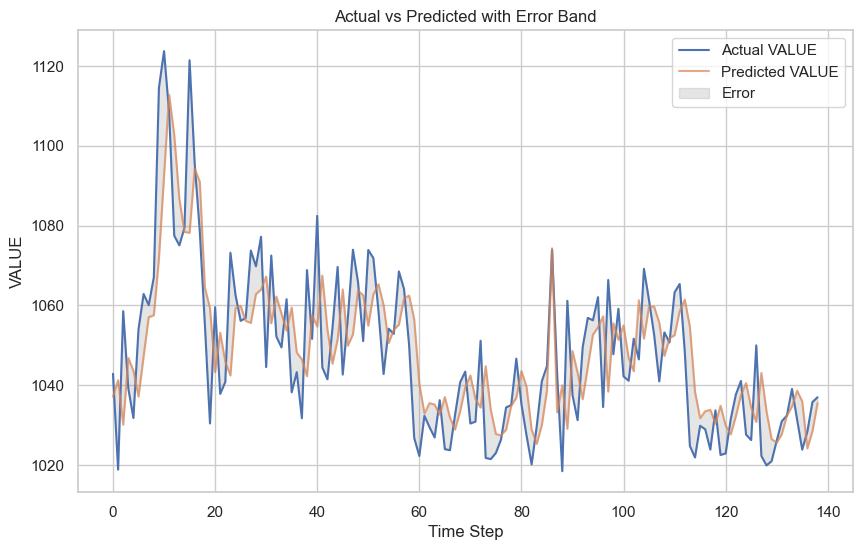

In [57]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual VALUE')
plt.plot(y_pred_test_actual, label='Predicted VALUE', alpha=0.7)
plt.fill_between(np.arange(len(y_test_actual)), y_test_actual.flatten(), y_pred_test_actual.flatten(), color='gray', alpha=0.2, label='Error')
plt.title('Actual vs Predicted with Error Band')
plt.xlabel('Time Step')
plt.ylabel('VALUE')
plt.legend()
plt.show()

In [58]:
import numpy as np

# Define how many steps to predict (for 2 years and 4 years into the future)
steps_2_years = 24  # 2 years = 24 months
steps_4_years = 48  # 4 years = 48 months

# Last 12 values from the test set to start the predictions (based on scaled values)
last_12_values = df2[['VALUE_Lag_1', 'VALUE_Lag_2', 'VALUE_Lag_3', 'VALUE_Lag_4', 'VALUE_Lag_5', 
                      'VALUE_Lag_6', 'VALUE_Lag_7', 'VALUE_Lag_8', 'VALUE_Lag_9', 'VALUE_Lag_10', 
                      'VALUE_Lag_11', 'VALUE_Lag_12']].values[-1].reshape(1, -1, 1)

# Function to predict future values
def predict_future(model, steps, last_values):
    future_predictions = []
    current_values = last_values

    for _ in range(steps):
        # Predict the next value
        prediction = model.predict(current_values)
        future_predictions.append(prediction[0, 0])

        # Update the lagged values: remove the oldest, add the new prediction
        current_values = np.roll(current_values, -1)
        current_values[0, -1, 0] = prediction

    return np.array(future_predictions)

# Predict future values for 2 years
predictions_2_years = predict_future(model, steps_2_years, last_12_values)

# Predict future values for 4 years
predictions_4_years = predict_future(model, steps_4_years, last_12_values)


1/1 [==============================] - 0s 26ms/step


In [59]:
# Invert the scaling for both 2-year and 4-year predictions
predictions_2_years_actual = scaler.inverse_transform(predictions_2_years.reshape(-1, 1))
predictions_4_years_actual = scaler.inverse_transform(predictions_4_years.reshape(-1, 1))


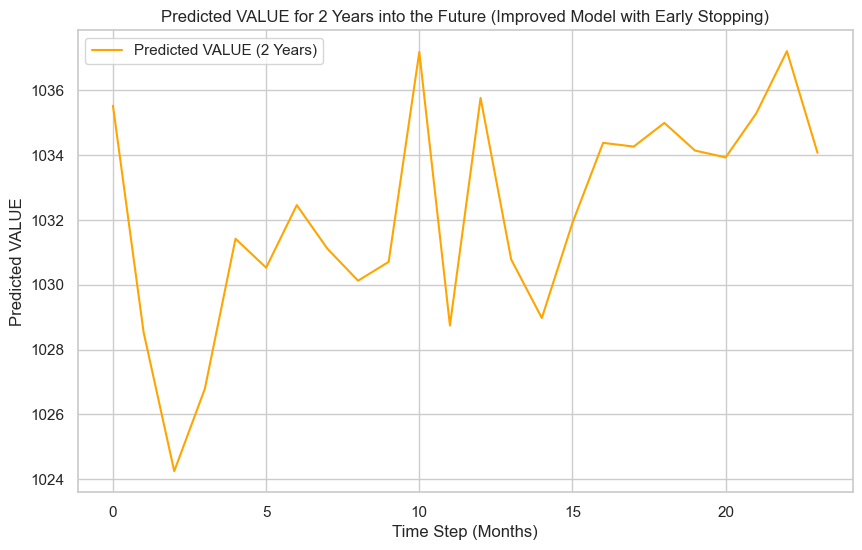

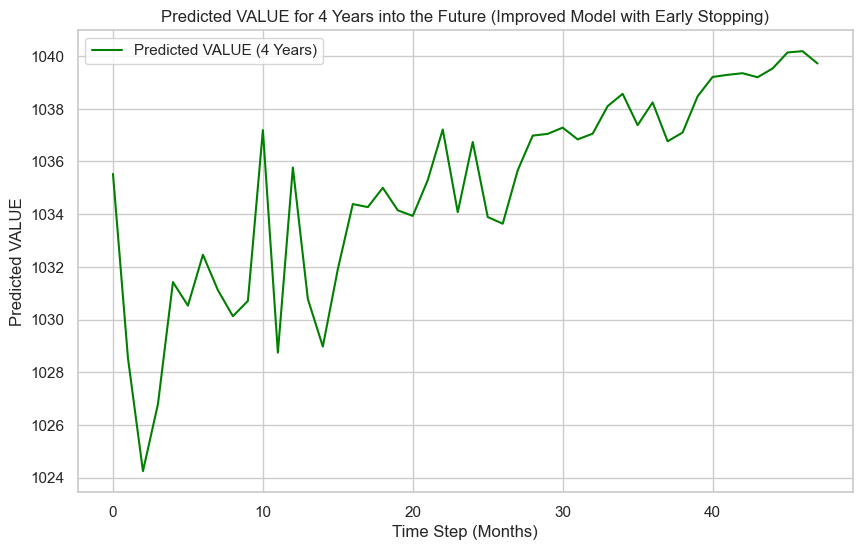

In [60]:
import matplotlib.pyplot as plt

# Plot the predictions for 2 years
plt.figure(figsize=(10,6))
plt.plot(predictions_2_years_actual, label='Predicted VALUE (2 Years)', color='orange')
plt.title('Predicted VALUE for 2 Years into the Future (Improved Model with Early Stopping)')
plt.xlabel('Time Step (Months)')
plt.ylabel('Predicted VALUE')
plt.legend()
plt.show()

# Plot the predictions for 4 years
plt.figure(figsize=(10,6))
plt.plot(predictions_4_years_actual, label='Predicted VALUE (4 Years)', color='green')
plt.title('Predicted VALUE for 4 Years into the Future (Improved Model with Early Stopping)')
plt.xlabel('Time Step (Months)')
plt.ylabel('Predicted VALUE')
plt.legend()
plt.show()

- The graph of the forecasts for 2 years (24 months) from Ireland, shows significant variations in the first few months, with both upward and downward fluctuations in the forecast values. This suggests that the model captures both short-term trends and seasonal variations over the period.

- The 4-year (48-month) forecasts show a similar pattern to the 2-year forecast, but with smoother fluctuations, especially after the first 12 months. Predictability increases over time, suggesting that the model expects rental values to stabilize in the long term.
